In [3]:
import json
import numpy as np
import pickle
from itertools import combinations
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import matplotlib.ticker as mticker
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', None)
%matplotlib inline

## Import data

In [4]:

df_participants = pd.read_csv('./data/df_participants.csv')
sample_size = len(df_participants)
sample_size_exps = np.array([60, 120, 120, 120])
print('Sample size:', sample_size)

df_trials = pd.read_csv('./data/df_trials.csv')
experiments = df_trials.experiment.unique().tolist()
print(experiments)


interventions = pd.read_csv('./data/df_interventions.csv')

Sample size: 420
['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']


In [5]:
interventions['error'] = (interventions['effect_1_error'] + interventions['effect_2_error']).astype(float)
interventions['accuracy'] = interventions.error.max() - interventions.error

def links_type(link_1, link_2):
    if np.abs(link_1) + np.abs(link_2) == 0:
        return '2_no_link'
    elif link_1 == 0 or link_2 == 0:
        return '1_no_link_&_1_link'
    else:
        return '2_links'


interventions['link_cases'] = interventions.apply(lambda x: links_type(x.effect_1, x.effect_2), axis=1)
interventions['link_cases_prior'] = interventions.apply(lambda x: links_type(x.effect_1_prior, x.effect_2_prior), axis=1)
logscale_increment = 1e-1

interventions.swipes = interventions.swipes + logscale_increment

In [6]:
interventions.columns

Index(['experiment', 'pid', 'utid', 'uiid', 'trial_type', 'trial', 'trial_idx',
       'int_idx', 'var_inter_idx', 'variable', 'prior_type', 'gt_type',
       'var_position', 'int_num', 'pos_in_trial', 'length', 'length_sec',
       'relative_length', 'swipes', 'swipes10', 'abs_mean_idle', 'idle_freq',
       'distance_travelled', 'min', 'max', 'avg', 'sd', 'mean_abs', 'std_abs',
       'mode_abs', 'mode_abs_len', 'mode_abs_len_rel', 'range', 'relevant',
       'num_inters', 'effect_1_label', 'effect_2_label', 'effect_1',
       'effect_2', 'effect_1_prior', 'effect_2_prior', 'effect_1_estimate',
       'effect_2_estimate', 'effect_1_error', 'effect_2_error', 'dataValid',
       'inters', 'inters_real', 'error', 'accuracy', 'link_cases',
       'link_cases_prior'],
      dtype='object')

# Interventions

## General statistics about interventions

### Sample level statistics

- Length
- Number of interventions per trial
- Number of intervention per variable
- Intervention time

In [7]:
all_p = True

if all_p:

    print('Number of interventions:', len(interventions))
    #print('Average number of interventions per participants:', len(interventions) / sample_size)
    print('Average number of interventions per trial:', len(interventions) / (sample_size * 4))
    print(f'Mean intervention length: {interventions.length_sec.mean()}')
    print(f'Std intervention length: {interventions.length_sec.std()}')

    print(f'Mean intervening time (in %): {interventions.groupby("utid").relative_length.sum().mean()}')
    print(f'Std intervening time (in %): {interventions.groupby("utid").relative_length.sum().std()}')


for i, experiment in enumerate(experiments):
    interventions_exp = interventions[interventions.experiment == experiment]
    print(f'\n {experiment}')
    #print('Number of interventions:', len(interventions_exp))
    #print('Average number of interventions per participants:', len(interventions_exp) / sample_size_exps[i])
    print('Average number of interventions per trial:', len(interventions_exp) / (sample_size_exps[i] * 4))
    print(f'Mean intervention length: {interventions_exp.length_sec.mean()}')
    print(f'Std intervention length: {interventions_exp.length_sec.std()}')

    print(f'Mean intervening time (in %): {interventions_exp.groupby("utid").relative_length.sum().mean()}')
    print(f'Std intervening time (in %): {interventions_exp.groupby("utid").relative_length.sum().std()}')



Number of interventions: 14445
Average number of interventions per trial: 8.598214285714286
Mean intervention length: 3.1194877120110767
Std intervention length: 3.3999511722212374
Mean intervening time (in %): 0.435264321095458
Std intervening time (in %): 0.1924276896430353

 experiment_1
Average number of interventions per trial: 7.183333333333334
Mean intervention length: 3.377958236658933
Std intervention length: 3.955648078339496
Mean intervening time (in %): 0.4382600842865739
Std intervening time (in %): 0.19909165762183534

 experiment_2
Average number of interventions per trial: 8.264583333333333
Mean intervention length: 3.1592135114696247
Std intervention length: 3.3591206535103924
Mean intervening time (in %): 0.44241658312034854
Std intervening time (in %): 0.19078079244066132

 experiment_3
Average number of interventions per trial: 8.410416666666666
Mean intervention length: 3.023680951201387
Std intervention length: 3.3748375176930856
Mean intervening time (in %): 0.44

Stats per participant, mean: 35.57881773399015 std: 15.228552537761116
Stats per trial, mean: 8.427654609101516 std: 4.373432652839166


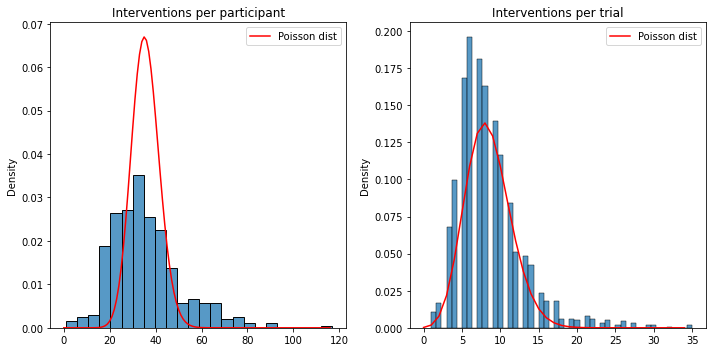

In [8]:

pids = interventions.pid.unique()

num_trials = 0

num_int_pid = np.zeros(pids.size)
num_int_trial = []
links_cases_freq = np.zeros(interventions.link_cases.unique().size)

for i, pid in enumerate(pids):
    pid_ints = interventions[interventions.pid == pid]
    num_int_pid[i] = len(pid_ints)
    trials = pid_ints.trial.unique()
    num_trials += len(trials)
    for j, t in enumerate(trials):
        num_int_trial.append(len(pid_ints[pid_ints.trial == t]))

        trial_data = pid_ints[pid_ints.trial == t]

        variables = trial_data.variable.unique()
        
        for v in variables:
        
            trial_links_cases = trial_data[trial_data.variable == v].link_cases.unique()

            if '2_no_link' in trial_links_cases:
                links_cases_freq[0] += 1
            elif '1_no_link_&_1_link' in trial_links_cases:
                links_cases_freq[2] += 1
            elif '2_links' in trial_links_cases:
                links_cases_freq[1] += 1

num_int_trial = np.array(num_int_trial)
print('Stats per participant, mean:', num_int_pid.mean(), 'std:', num_int_pid.std())
print('Stats per trial, mean:', num_int_trial.mean(), 'std:', num_int_trial.std())

pid_x = np.arange(num_int_pid.max())
pid_pois = stats.poisson.pmf(pid_x, mu=num_int_pid.mean())

trial_x = np.arange(num_int_trial.max())
trial_pois = stats.poisson.pmf(trial_x, mu=num_int_trial.mean())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(num_int_pid, stat='density')
plt.plot(pid_x, pid_pois, color='red',label='Poisson dist')
plt.legend()
plt.title('Interventions per participant')

plt.subplot(1, 2, 2)
sns.histplot(num_int_trial, stat='density')
plt.plot(trial_x, trial_pois, color='red', label='Poisson dist')
plt.legend()
plt.title('Interventions per trial')

plt.tight_layout()

plt.show()

Mean intervention length (in %): 3.1194877120110767
Std intervention length (in %): 3.3999511722212374
Mean intervening time (in %): 0.435264321095458
Std intervening time (in %): 0.1924276896430353


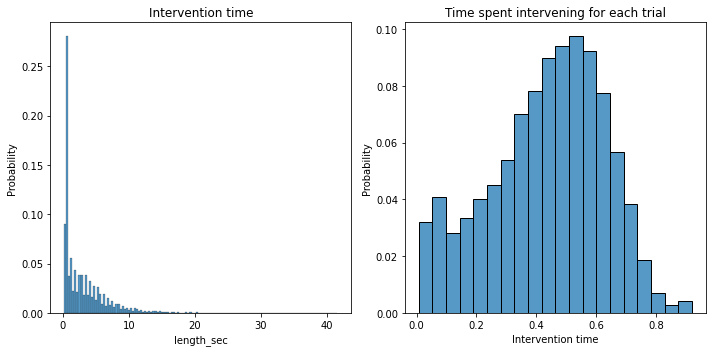

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

print(f'Mean intervention length (in %): {interventions.length_sec.mean()}')
print(f'Std intervention length (in %): {interventions.length_sec.std()}')

print(f'Mean intervening time (in %): {interventions.groupby("utid").relative_length.sum().mean()}')
print(f'Std intervening time (in %): {interventions.groupby("utid").relative_length.sum().std()}')

sns.histplot(interventions.length_sec, ax=axs[0], stat='probability')
axs[0].set_title('Intervention time')

sns.histplot(interventions.groupby('utid').relative_length.sum(), ax=axs[1], stat='probability')
axs[1].set_xlabel('Intervention time')
axs[1].set_title('Time spent intervening for each trial')

plt.tight_layout()
plt.show()

In [12]:
trials = interventions.utid.unique()

cols = ['experiment', 'pid', 'utid', 'trial_type', 'trial', 'variable', 'prior_type', 'gt_type', 'var_position', 
       'link_cases',
       'effect_1_label', 'effect_2_label', 'effect_1', 'effect_2', 
       'effect_1_estimate', 'effect_2_estimate', 
       'effect_1_error', 'effect_2_error', 'error', 'accuracy']

cols_aggregate = [
    'length', 'length_sec', 'relative_length', 'swipes', 'idle_freq'
]
inter_trials = pd.DataFrame(columns=cols + cols_aggregate)

for i, t in enumerate(trials):
    int_t = interventions[interventions.utid == t]

    variables = int_t.variable.unique()

    for j, v in enumerate(variables):

        int_v = int_t[int_t.variable == v]

        inter_trials.loc[inter_trials.index.size, cols] = int_v.loc[int_v.index[0], cols]

        inter_trials.loc[inter_trials.index[-1], cols_aggregate] = int_v[cols_aggregate].mean()

#int_t[int_t.variable == variables[0]].sum()

In [13]:
inter_trials.relative_length = inter_trials.relative_length.astype(float)
inter_trials.error = inter_trials.error.astype(float)
inter_trials.accuracy = inter_trials.accuracy.astype(float)

In [14]:
inter_trials.head()

,experiment,pid,utid,trial_type,trial,variable,prior_type,gt_type,var_position,link_cases,effect_1_label,effect_2_label,effect_1,effect_2,effect_1_estimate,effect_2_estimate,effect_1_error,effect_2_error,error,accuracy,length,length_sec,relative_length,swipes,idle_freq
0,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,generic_0,ccause_3,effect2,NaN,leaf,0,2_no_link,cause,effect1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,3.4,0.056291,1.6,0.634921
1,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,generic_0,ccause_3,effect1,NaN,leaf,1,2_no_link,cause,effect2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,43.0,8.6,0.142384,3.1,0.511628
2,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,generic_0,ccause_3,cause,NaN,root,2,2_links,effect1,effect2,1.0,1.0,0.5,0.5,0.5,0.5,1.0,3.0,40.5,8.1,0.134106,2.1,0.782819
3,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-collider_2-generic_1,generic_1,collider_2,effect,NaN,leaf,0,2_no_link,cause1,cause2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,55.0,11.0,0.182119,1.6,0.624611
4,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-collider_2-generic_1,generic_1,collider_2,cause2,NaN,root,1,1_no_link_&_1_link,cause1,effect,0.0,-1.0,0.0,0.5,0.0,1.5,1.5,2.5,42.0,8.4,0.139073,2.1,0.880952


In [15]:
inter_trials_34 = inter_trials[inter_trials.experiment.isin(['experiment_3', 'experiment_4'])]

combs = [comb for comb in combinations(inter_trials.link_cases.unique(), 2)]
#print(combs)
print(inter_trials.link_cases.unique())
swipes = []
hold = []
N_swipes = []
for i, case in enumerate(inter_trials.link_cases.unique()):
    swipes.append(inter_trials[inter_trials.link_cases == case].swipes)
    hold.append(inter_trials[inter_trials.link_cases == case].idle_freq)
    N_swipes.append(inter_trials[inter_trials.link_cases == case].shape[0])


print('Swipes', inter_trials.groupby('link_cases').swipes.mean())
print('Swipes:', stats.f_oneway(*swipes), f'N={N_swipes}')
for comb in combs:
    s1 = inter_trials[inter_trials.link_cases == comb[0]].swipes
    s2 = inter_trials[inter_trials.link_cases == comb[1]].swipes
    print(f'{comb}: {stats.ttest_ind(s1, s2)}, N_1={s1.size}, N_2={s2.size}')

print()
print('Holding', inter_trials.groupby('link_cases').idle_freq.mean())
print('Holds:', stats.f_oneway(*hold), f'N={inter_trials.groupby("link_cases").idle_freq.count().sum()}')
for comb in combs:
    s1 = inter_trials[inter_trials.link_cases == comb[0]].idle_freq
    s2 = inter_trials[inter_trials.link_cases == comb[1]].idle_freq
    print(f'{comb}: {stats.ttest_ind(s1, s2)}, N_1={s1.size}, N_2={s2.size}')

['2_no_link' '2_links' '1_no_link_&_1_link']
Swipes link_cases
1_no_link_&_1_link    1.548407
2_links               1.450187
2_no_link             1.983840
Name: swipes, dtype: float64
Swipes: F_onewayResult(statistic=77.74697301912376, pvalue=5.617065460576635e-34) N=[1242, 1996, 1763]
('2_no_link', '2_links'): Ttest_indResult(statistic=11.938357305454975, pvalue=3.505289503416809e-32), N_1=1242, N_2=1996
('2_no_link', '1_no_link_&_1_link'): Ttest_indResult(statistic=8.917508688892127, pvalue=8.104806333616531e-19), N_1=1242, N_2=1763
('2_links', '1_no_link_&_1_link'): Ttest_indResult(statistic=-2.6923870162671943, pvalue=0.007125728144468732), N_1=1996, N_2=1763

Holding link_cases
1_no_link_&_1_link    0.621363
2_links               0.641762
2_no_link             0.541528
Name: idle_freq, dtype: float64
Holds: F_onewayResult(statistic=77.51395411632383, pvalue=7.04140496744659e-34) N=5001
('2_no_link', '2_links'): Ttest_indResult(statistic=-12.00758175468588, pvalue=1.57641176620543

['No link' 'Two links' 'One link']


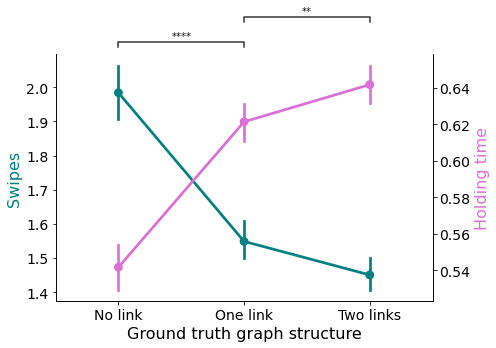

In [16]:

box_pairs = [
    ('No link', 'One link'),
    ('One link', 'Two links')
]

p_values = [
    0.0001,
    0.01
]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

x = 'link_cases'
y1 = 'swipes'
y2 = 'idle_freq'
df_plot = inter_trials.replace({'2_no_link':'No link', '2_links':'Two links', '1_no_link_&_1_link':'One link'})
order_case = ['No link', 'One link', 'Two links']
print(df_plot.link_cases.unique())
sns.pointplot(x=x, y=y1, data=df_plot, linewiscale=1.5, ax=ax, order=order_case, ci=95, color='teal')
ax2 = ax.twinx()
sns.pointplot(x=x, y=y2, data=df_plot, ax=ax2, alpha=0.5, order=order_case, ci=95, color='orchid')

annotator = Annotator(ax, box_pairs, data=df_plot, x=x, y=y1, order=order_case, verbose=False)
annotator.configure(test_short_name="Tukey's range test", loc='outside', show_test_name=True)
annotator.set_pvalues(p_values)
annotator.annotate()

ax.set_ylabel('Swipes', color='teal', fontsize=16)
ax2.set_ylabel('Holding time', color='orchid', fontsize=16)

ax.set_xlabel('Ground truth graph structure', fontsize=16)

plt.setp(ax.get_yticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)

sns.despine(right=False)
plt.tight_layout()

### Predicting accuracy for intervention time

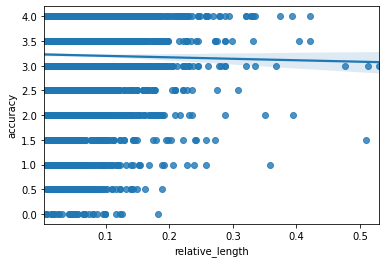

In [17]:
sns.regplot(y='accuracy', x='relative_length', data=inter_trials)
plt.show()

### Key statstics to describe a single intervention

We consider that the space $[-100, 100]$ can be considered symmetrical and thus the absolute value can be taken. Moreover, the tendency to hold variable at or around one value puts emphasis on the mode of the intervention rather than its mean or median.

#### No free parameter

- Length 
- Distance travelled
- Absolute mode
- Relative time spent on the mode

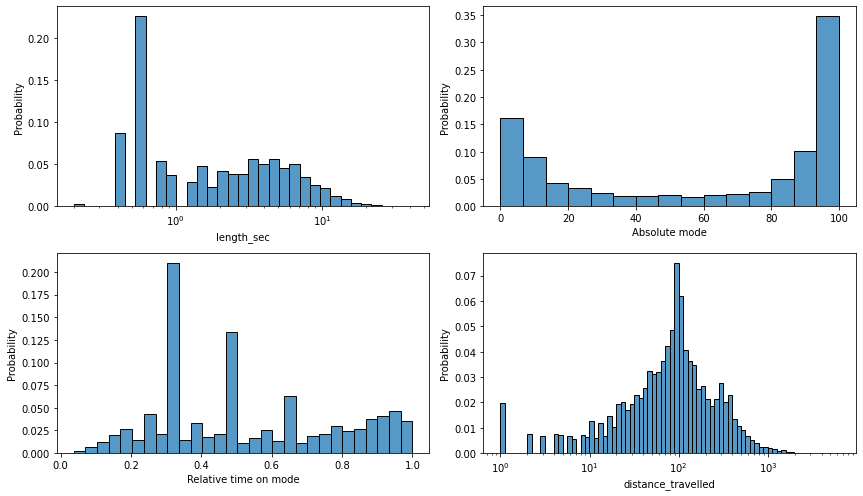

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

sns.histplot(interventions.length_sec, ax=axs[0, 0], stat='probability', log_scale=True)

sns.histplot(interventions.mode_abs, ax=axs[0, 1], stat='probability')
axs[0, 1].set_xlabel('Absolute mode')

sns.histplot(interventions.mode_abs_len_rel, ax=axs[1, 0], stat='probability')
axs[1, 0].set_xlabel('Relative time on mode')

sns.histplot((interventions.distance_travelled + 1).astype(float), ax=axs[1, 1], stat='probability', log_scale=True)

plt.tight_layout()
plt.show()

#### Assuming a "holding" threshold ($s = 10$)

Here we assume that "holding" can be defined as keep the variable within a certain range. Therefore we use a parameter which controls the range within which any change in value is considered not significant. This parameter allows us to define more precise statistics about interventions and to recreate approximate path from them

- Length: same as before
- Swipes: the number of times the direction of change has changed (could be generalised to how often change started again after being held at a single value)
- Held mean value: the mean absolute value the variable had during held time
- Held time: the relative time spent maintaining a variable within the holding threshold

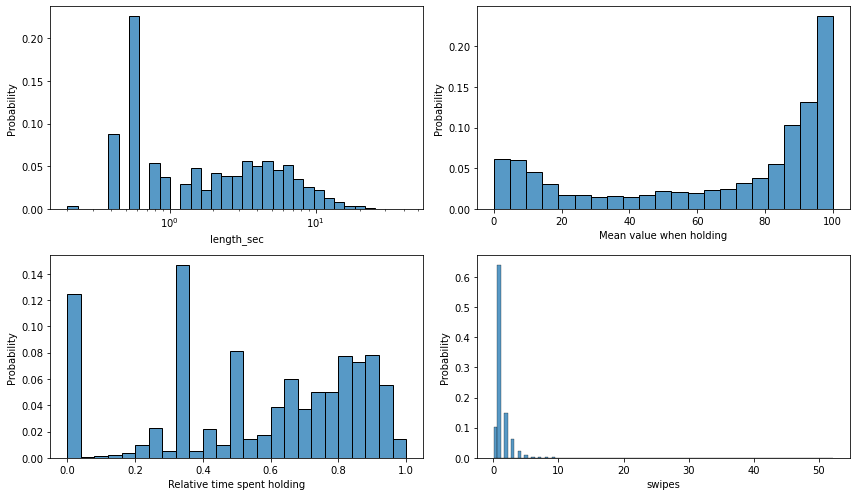

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

sns.histplot(interventions.length_sec, ax=axs[0, 0], stat='probability', log_scale=True)

sns.histplot(interventions.abs_mean_idle, ax=axs[0, 1], stat='probability')
axs[0, 1].set_xlabel('Mean value when holding')

sns.histplot(interventions.idle_freq, ax=axs[1, 0], stat='probability')
axs[1, 0].set_xlabel('Relative time spent holding')

sns.histplot(interventions.swipes, ax=axs[1, 1], stat='probability', bins=100)

plt.tight_layout()
plt.show()

## Clustering

We can use a Gaussian mixture to extract different types of interventions. We expect the following large families from qualitative observations:
1. Short interventions (< 1 sec)
    - Behavioural noise interventions: clicks with value close to 0
    - Intentional clicks: clicks with value above 30~35
2. Long interventions (> 1 sec)
    - Swipe up: 1 swipe, with a long holding time and large held mean value
    - Swipes up and down: 2 swipes, with a long holding time and large held mean value
    - Mutliple swipes: >2 swipes, with a long holding time and large held mean value
    - Wiggles: >2 swipes, moderate holding time and moderate held mean value

This suggests looking at models with 6 components initially

In [20]:
experiments = [
    'experiment_1',
    'experiment_2',
    'experiment_3',
    'experiment_4']
cols = ['length_sec', 'mode_abs', 'distance_travelled', 'mode_abs_len_rel']
interventions['log_length_sec'] = np.log10(interventions.length_sec)
#cols = ['length_sec', 'mode_abs', 'mode_abs_len_rel']
cols = ['length_sec', 'mode_abs', 'swipes10', 'mode_abs_len_rel']
features = ['log_length_sec', 'abs_mean_idle', 'swipes', 'idle_freq']
#cols = ['length_sec', 'abs_mean_idle', 'distance_travelled', 'idle_freq']
selected_columns = ['uiid'] + features
df = interventions[interventions.experiment.isin(experiments)][selected_columns]
X = df[features].to_numpy().astype(float)


In [23]:
n_components = np.arange(3, 8)
covariances = ['full', 'diag']

num_samples = 15

model_selection = pd.DataFrame(columns=['n_comp', 'cov', 'bic'])
for c in n_components:
    for cov in covariances:
        for i in range(num_samples):
            gm = GaussianMixture(n_components=c, covariance_type=cov).fit(X)
            model_selection.loc[model_selection.index.size] = [c, cov, gm.bic(X)]

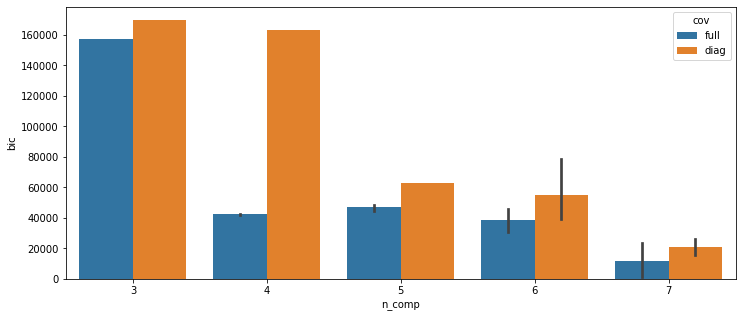

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x='n_comp', y='bic', hue='cov', data=model_selection, ax=ax)

plt.show()

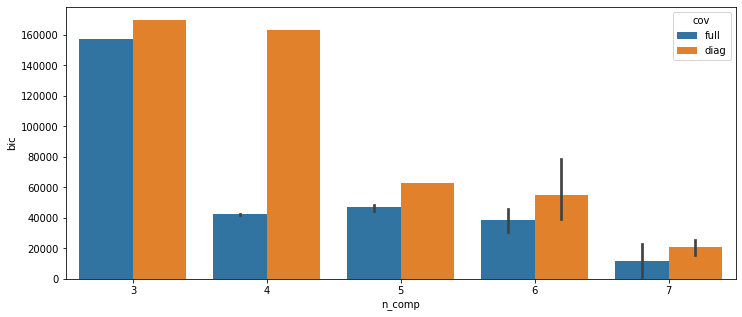

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x='n_comp', y='bic', hue='cov', data=model_selection, ax=ax)

plt.show()

## Bayesian Gaussian Mixture

[0.2422 0.0984 0.3637 0.0238 0.2069 0.065 ]

[[ 0.5685 93.1544  1.1001  0.8254]
 [ 0.1729 71.2402  1.858   0.468 ]
 [-0.1591 48.662   1.1001  0.2669]
 [ 0.7672 75.1255  7.2656  0.4853]
 [ 0.7714 77.1884  2.2629  0.7964]
 [-0.2692 12.8326  0.1015  0.6272]]

[[ 0.2385  6.938   0.0259  0.0967]
 [ 0.3322 27.3642  1.1982  0.2466]
 [ 0.1687 37.0786  0.0212  0.2041]
 [ 0.2775 21.3351  5.3428  0.2338]
 [ 0.2243 20.9596  1.0291  0.1064]
 [ 0.1795 11.5151  0.0663  0.133 ]]


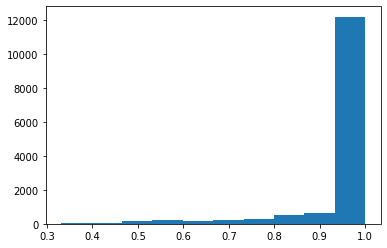

In [18]:
num_components = 6
cov = 'diag'

gm = BayesianGaussianMixture(n_components=num_components, covariance_type=cov).fit(X)
np.set_printoptions(suppress=True)

print(np.round(gm.weights_, 4))
print()
print(np.round(gm.means_, 4))
print()
print(np.round(gm.covariances_**(1/2), 4))

plt.hist(gm.predict_proba(X).max(axis=1))
plt.show()

### Using 6 components

BIC: 40172.86130872689
[0.1017 0.2814 0.037  0.0576 0.1635 0.3589]

[[-0.1214 37.0705  0.1     0.6821]
 [ 0.5688 87.6285  1.1     0.8208]
 [ 0.7177 72.7299  6.207   0.4849]
 [ 0.2267 67.0495  2.245   0.3819]
 [ 0.7903 82.345   2.5906  0.7722]
 [-0.1652 48.5333  1.1     0.2611]]

[[ 0.3856 36.457   0.001   0.1723]
 [ 0.2384 16.6446  0.001   0.102 ]
 [ 0.3017 23.0465  4.5458  0.2358]
 [ 0.2538 29.2975  0.3525  0.2335]
 [ 0.2169 16.7079  0.6763  0.1042]
 [ 0.1613 37.3024  0.001   0.1995]]


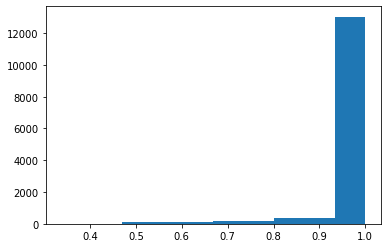

In [49]:
num_components = 6
cov = 'diag'

gm = GaussianMixture(n_components=num_components, covariance_type=cov).fit(X)

print(f'BIC: {gm.bic(X)}')
print(np.round(gm.weights_, 4))
print()
print(np.round(gm.means_, 4))
print()
print(np.round(gm.covariances_**(1/2), 4))

plt.hist(gm.predict_proba(X).max(axis=1))
plt.show()

In [19]:
df_mixture = pd.DataFrame(index=np.arange(gm.means_.shape[0]), columns=features, data=gm.means_)
df_mixture

,log_length_sec,abs_mean_idle,swipes,idle_freq
0,0.568505,93.154438,1.100113,0.825350
1,0.172869,71.240182,1.858024,0.468048
2,-0.159064,48.661975,1.100076,0.266923
3,0.767183,75.125537,7.265568,0.485263
4,0.771393,77.188436,2.262935,0.796362
5,-0.269172,12.832570,0.101484,0.627176


In [20]:
a = gm.predict(X)

interventions['assignment'] = a

assign_order = interventions.groupby('assignment').length_sec.mean().sort_values().index

palette = sns.color_palette("Set2")

assign_colors = {k:v for k,v in zip(assign_order, palette[:len(assign_order)])}

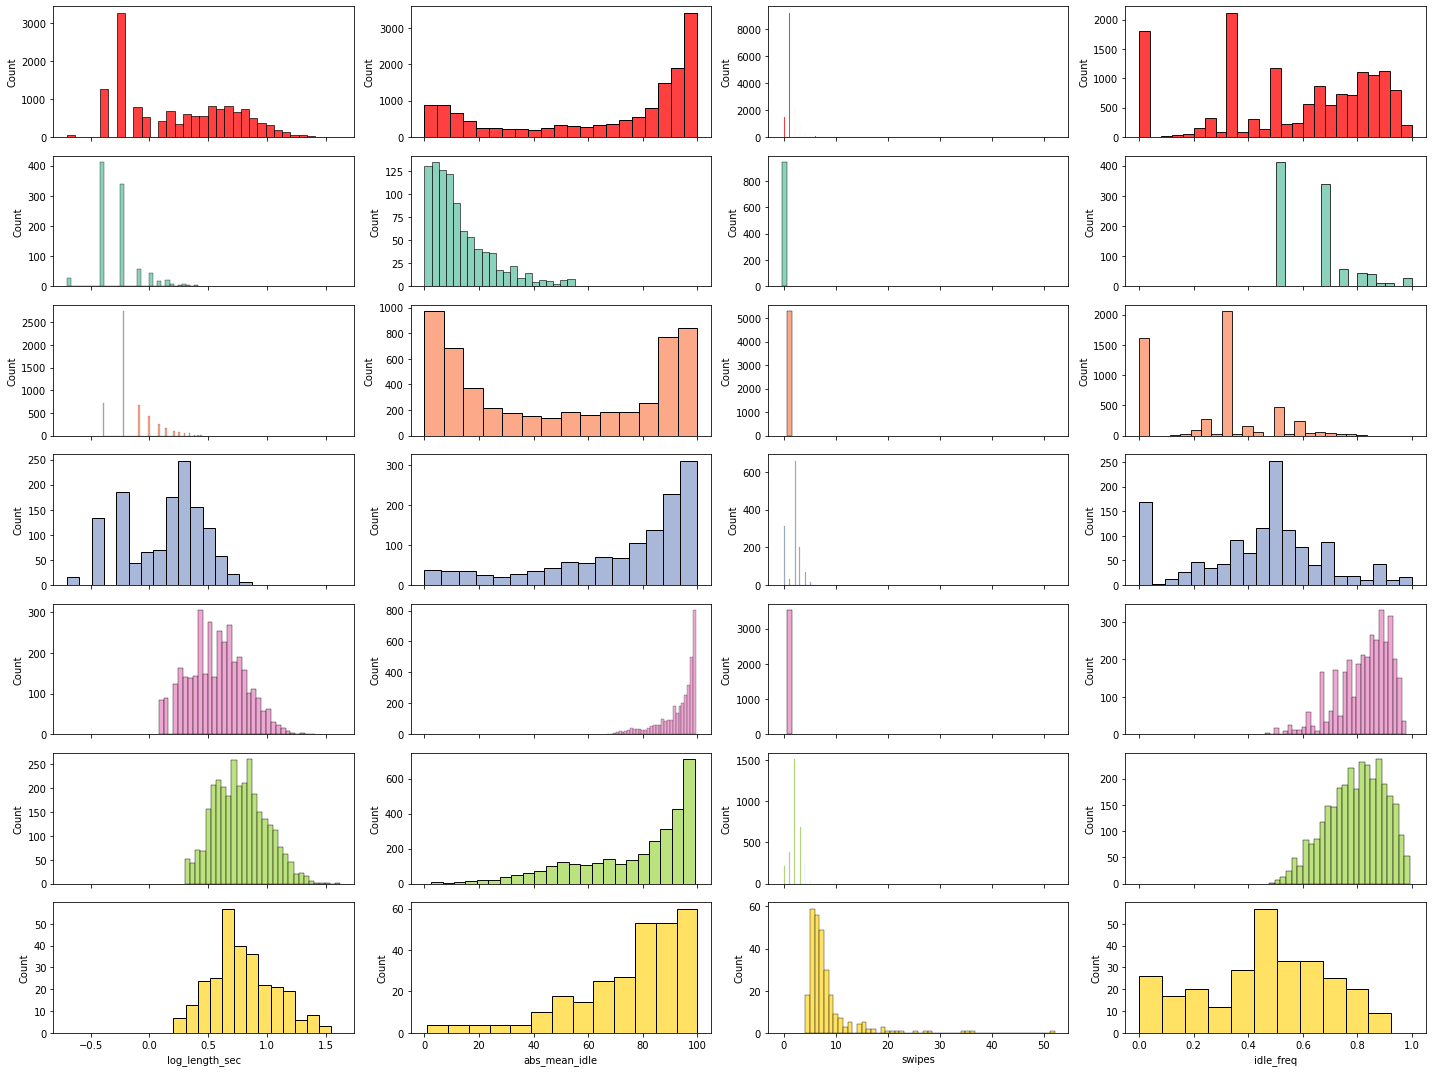

In [21]:
fig, axs = plt.subplots(num_components+1, len(features), figsize=(20, 15), sharex='col')
for j in range(len(features)):
    if j == 0:
        log_scale = False
    else:
        log_scale = False

    if j == 2:
        sns.histplot(interventions[features[j]], ax=axs[0, j], color='red', log_scale=log_scale)
    else:
        sns.histplot(interventions[features[j]], ax=axs[0, j], color='red', log_scale=log_scale)


for i, assign in enumerate(assign_order):
    inters_component = interventions[interventions.assignment == assign][features]
    #print(gm.means_[i, :])
    #print(inters_component.mean())

    for j in range(len(cols)):
        if j == 0:
            log_scale = False
        else:
            log_scale = False
        sns.histplot(inters_component[features[j]], ax=axs[i+1, j], log_scale=log_scale, color=assign_colors[assign])

plt.tight_layout()
plt.show()

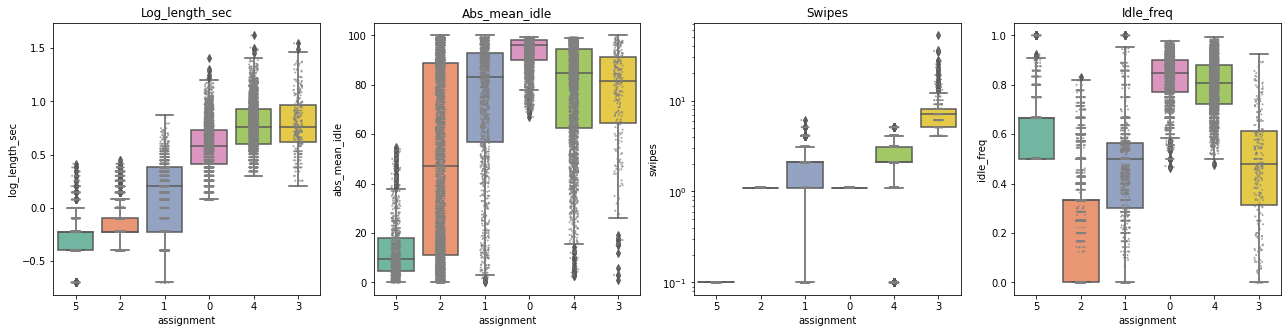

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))


for i, feature in enumerate(features):
    #if feature == 'log_length_sec':
    #    feature = 'length_sec'
    sns.stripplot(x='assignment', y=feature, data=interventions, s=2, alpha=0.7, color='grey', ax=axs[i], order=assign_order)
    sns.boxplot(x='assignment', y=feature, data=interventions, ax=axs[i], order=assign_order, palette=assign_colors)

    if feature == 'swipes':# or feature == 'length_sec':
        axs[i].set(yscale='log')

    axs[i].set_title(f'{feature.capitalize()}')

plt.show()

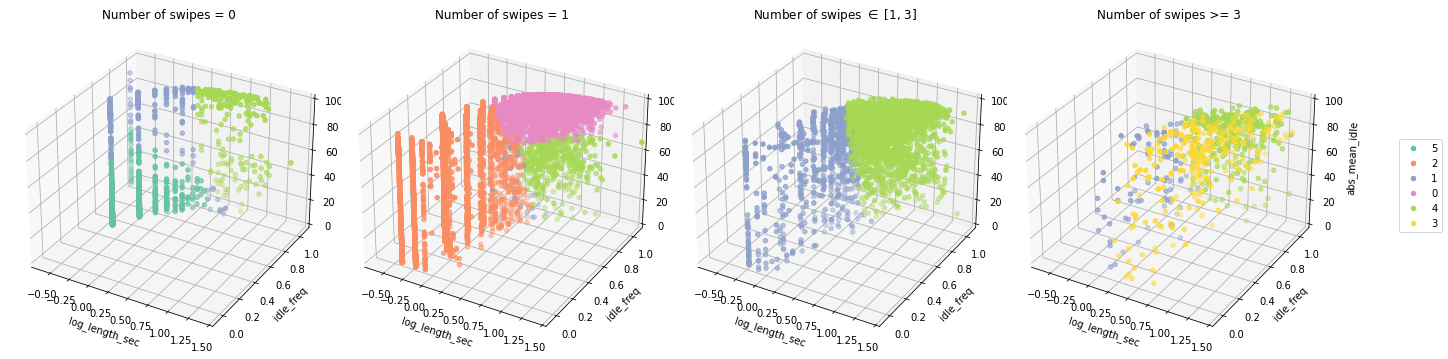

In [23]:
fig = plt.figure(figsize=(20, 5))

features_lims = {
    'log_length_sec': (-0.7, 1.5),
    'abs_mean_idle': (-1, 101),
    'idle_freq': (-0.1, 1.1)
}

swipes = np.sort(interventions.swipes.unique()[:5])
swipes = np.array([0, 1, 3, 3]) + logscale_increment
select_order = [1, 3, 0]
feature_order = [
    'log_length_sec',
    'idle_freq',
    'abs_mean_idle'
]


for i, swipe in enumerate(swipes):
    ax = fig.add_subplot(1, len(swipes), i+1, projection='3d')
    if i == 0 or i == 1:
        data_swipe = interventions[interventions.swipes == swipe]
        ax.set_title(f'Number of swipes = {int(swipe)}')
    elif i < len(swipes) - 1:
        data_swipe = interventions[(interventions.swipes > swipes[i-1]) & (interventions.swipes <= swipe) ]
        ax.set_title(f'Number of swipes $\in$ [{int(swipes[i-1])}, {int(swipe)}]')
    else:
        data_swipe = interventions[interventions.swipes > swipe]
        ax.set_title(f'Number of swipes >= {int(swipe)}')
       
    
    for j, assign in enumerate(assign_order):
        feature_1 = data_swipe[data_swipe.assignment == assign][feature_order[0]]
        feature_2 = data_swipe[data_swipe.assignment == assign][feature_order[1]]
        feature_3 = data_swipe[data_swipe.assignment == assign][feature_order[2]]
        ax.scatter(feature_1, feature_2, feature_3, color=assign_colors[assign], label=assign)

        ax.set_xlim(*features_lims[feature_order[0]])
        ax.set_ylim(*features_lims[feature_order[1]])
        ax.set_zlim(*features_lims[feature_order[2]])
        ax.set_xlabel(feature_order[0])
        ax.set_ylabel(feature_order[1])
        ax.set_zlabel(feature_order[2])

    
    if i == len(swipes) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

#### Naming the clusters

It seems that intentional clicks are not represented, as they may be too few. We have the following:

1. Short interventions (< 1 sec)
    - Noise: behavioural noise interventions (index=1, color=cyan), clicks with value close to 0
    - Single swipe: swipe wo holding (index=2, color=orange), clicks with value above 30~35
2. Long interventions (> 1 sec)
    - Unnamed: medium length intervention with relatively low holding time and wide spanning average held value (index=5)
    - Swipe & Hold: 1 swipe, with a long holding time at large absolute value (index=0) 
    - Multiple swipes & long hold: 2-3 swipes with a long holding time at large absolute value (index=4)
    - Multiple swipes & medium hold: long interventions with 3 or more swipes, about 50% holding time and large held mean values (index=3)

In [24]:


components_labels = [
    'noise',
    'short_1_swipe_&_no_hold',
    'med_23_swipes_&_med_hold',
    'long_1_swipe_&_long_hold',
    'long_double_swipes_&_long_hold',
    'long_multi_swipes_&_med_hold',
]

components_labels_clean = [
    'Behavioural noise',
    'Single swipe',
    'Double swipes, medium hold',
    'Single swipe, long hold',
    'Double swipes, long hold',
    'Multiple swipes, medium hold',
]

labels = {k:v for k, v in zip(assign_order, components_labels)}
print(labels)
labels_clean = {k:v for k, v in zip(assign_order, components_labels_clean)}

interventions['assignment_labels'] = interventions['assignment'].apply(lambda x: labels[x])
interventions['assignment_labels_clean'] = interventions['assignment'].apply(lambda x: labels_clean[x])

df_mixture['assignment'] = df_mixture.index

df_mixture['assignment_labels'] = df_mixture['assignment'].apply(lambda x: labels[x])
df_mixture = df_mixture[['assignment_labels'] + features]

assign_label_order = [labels[i] for i in assign_order]
assign_label_colors = {assign_label:assign_colors[assign] for assign_label, assign in zip(assign_label_order, assign_order)}
assign_label_order_clean = [labels_clean[i] for i in assign_order]
assign_label_colors_clean = {assign_label:assign_colors[assign] for assign_label, assign in zip(assign_label_order_clean, assign_order)}
#print(assign_label_colors_clean)
df_mixture

{5: 'noise', 2: 'short_1_swipe_&_no_hold', 1: 'med_23_swipes_&_med_hold', 0: 'long_1_swipe_&_long_hold', 4: 'long_double_swipes_&_long_hold', 3: 'long_multi_swipes_&_med_hold'}


,assignment_labels,log_length_sec,abs_mean_idle,swipes,idle_freq
0,long_1_swipe_&_long_hold,0.568505,93.154438,1.100113,0.825350
1,med_23_swipes_&_med_hold,0.172869,71.240182,1.858024,0.468048
2,short_1_swipe_&_no_hold,-0.159064,48.661975,1.100076,0.266923
3,long_multi_swipes_&_med_hold,0.767183,75.125537,7.265568,0.485263
4,long_double_swipes_&_long_hold,0.771393,77.188436,2.262935,0.796362
5,noise,-0.269172,12.832570,0.101484,0.627176


In [25]:
interventions.assignment_labels_clean.value_counts(normalize=True)[assign_label_order_clean]

Behavioural noise               0.065421
Single swipe                    0.366563
Double swipes, medium hold      0.089373
Single swipe, long hold         0.244583
Double swipes, long hold        0.214607
Multiple swipes, medium hold    0.019453
Name: assignment_labels_clean, dtype: float64

C:\Users\vbtes\AppData\Local\Temp/ipykernel_12844/3252062042.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


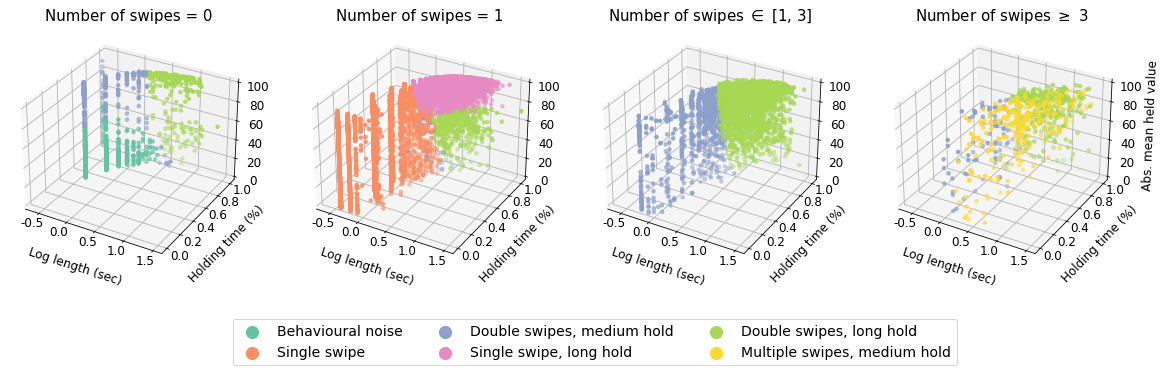

In [26]:
fig = plt.figure(figsize=(20, 20))

features_lims = {
    'log_length_sec': (-0.7, 1.6),
    'abs_mean_idle': (-1, 101),
    'idle_freq': (-0.05, 1.05)
}

swipes = np.sort(interventions.swipes.unique()[:5])
swipes = np.array([0, 1, 3, 3]) + logscale_increment
select_order = [1, 3, 0]
feature_order = [
    'log_length_sec',
    'idle_freq',
    'abs_mean_idle'
]
feature_order_clean = [
    'Log length (sec)',
    'Holding time (%)',
    'Abs. mean held value'
]


for i, swipe in enumerate(swipes):
    ax = fig.add_subplot(1, len(swipes), i+1, projection='3d')
    if i == 0 or i == 1:
        data_swipe = interventions[interventions.swipes == swipe]
        ax.set_title(f'Number of swipes = {int(swipe)}', fontsize=15)
    elif i < len(swipes) - 1:
        data_swipe = interventions[(interventions.swipes > swipes[i-1]) & (interventions.swipes <= swipe) ]
        ax.set_title(f'Number of swipes $\in$ [{int(swipes[i-1])}, {int(swipe)}]', fontsize=15)
    else:
        data_swipe = interventions[interventions.swipes > swipe]
        ax.set_title(f'Number of swipes $\geq$ {int(swipe)}', fontsize=15)
       
    
    for j, assign in enumerate(assign_order):
        feature_1 = data_swipe[data_swipe.assignment == assign][feature_order[0]]
        feature_2 = data_swipe[data_swipe.assignment == assign][feature_order[1]]
        feature_3 = data_swipe[data_swipe.assignment == assign][feature_order[2]]
        ax.scatter(feature_1, feature_2, feature_3, color=assign_colors[assign], label=assign_label_order_clean[j], s=12)

    
    ax.set_xlim(*features_lims[feature_order[0]])
    ax.set_ylim(*features_lims[feature_order[1]])
    ax.set_zlim(*features_lims[feature_order[2]])
    ax.set_xlabel(feature_order_clean[0], fontsize=12)
    ax.set_ylabel(feature_order_clean[1], fontsize=12)
    

    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(ticks_loc, fontsize=12, va='bottom')

    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([np.round(x, 2) for x in ticks_loc], fontsize=12, va='bottom')

    ticks_loc = ax.get_zticks().tolist()
    ax.zaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_zticklabels([int(x) for x in ticks_loc], fontsize=12)

    if i == len(swipes) - 1:
        ax.set_zlabel(feature_order_clean[2], fontsize=12)

    else:
        ax.set_zlabel('')
        #ax.set_zticklabels([])
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


    if i == len(swipes) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(-2.7, -0.3), fontsize=14, markerscale=3.5, ncol=3)


plt.tight_layout()
plt.show()

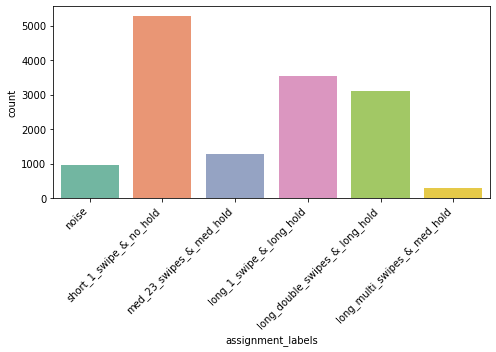

In [27]:
assign_label_order = [labels[i] for i in assign_order]
assign_label_colors = {assign_label:assign_colors[assign] for assign_label, assign in zip(assign_label_order, assign_order)}

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.countplot(x='assignment_labels', data=interventions, ax=ax, order=assign_label_order, palette=assign_label_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [28]:
assign_label_colors_clean

{'Behavioural noise': (0.4, 0.7607843137254902, 0.6470588235294118),
 'Single swipe': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'Double swipes, medium hold': (0.5529411764705883,
  0.6274509803921569,
  0.796078431372549),
 'Single swipe, long hold': (0.9058823529411765,
  0.5411764705882353,
  0.7647058823529411),
 'Double swipes, long hold': (0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235),
 'Multiple swipes, medium hold': (1.0, 0.8509803921568627, 0.1843137254901961)}

Components: ['noise', 'short_1_swipe_&_no_hold', 'med_23_swipes_&_med_hold', 'long_1_swipe_&_long_hold', 'long_double_swipes_&_long_hold', 'long_multi_swipes_&_med_hold']


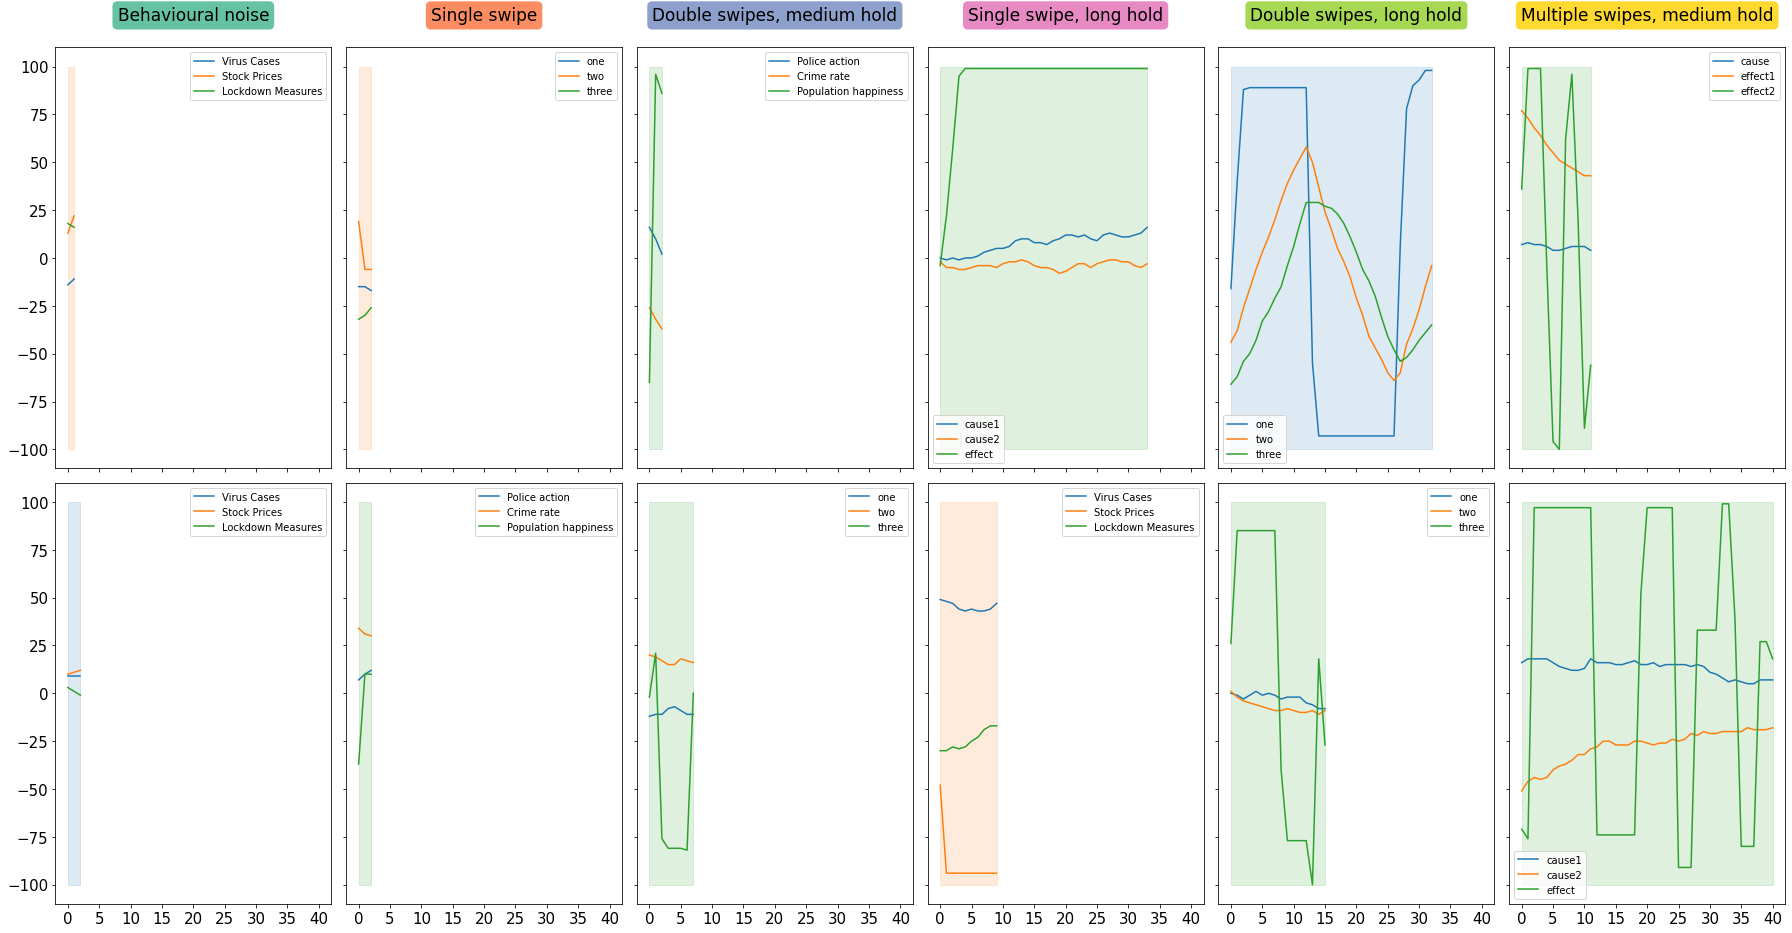

In [90]:
sample_size = 2

num_rows = len(components_labels)
num_cols = sample_size

fig, axs = plt.subplots(num_cols, num_rows, figsize=(25, 13), sharex=True, sharey=True)

samples_data = np.zeros((num_rows, num_cols, 4))
print(f'Components: {[labels[i] for i in assign_order]}')

for i, assign in enumerate(assign_order):

    samples = np.random.choice(interventions[interventions.assignment_labels == labels[assign]].uiid.to_list(), size=sample_size, replace=False)
    for j in range(num_cols):
        if j == 0:
            axs[j, i].set_title(f'{assign_label_order_clean[i]}', bbox=dict(facecolor=assign_label_colors_clean[assign_label_order_clean[i]], edgecolor='none', boxstyle='round,pad=0.3'), fontsize=17, y=1.05)

        
        order_vars = exp.df_trials[exp.df_trials.utid == samples[j][:-(1 + len(samples[j].split('-')[-1]))]].std_order[0].split('_')
    
        s_data = interventions.loc[interventions.uiid == samples[j], cols]
        
        #samples_data[i, j, :] = s_data.loc[s_data.index[0]].to_list()
        
        inter = exp.inters_db[samples[j]]
        #print(inter['length_sec'], inter['mode_abs'], inter['swipes10'], inter['mode_abs_len_rel'])
        plot_intervention(inter['variable'], inter['values'], order_vars, axs[j, i])
        #axs[j, i].set_facecolor('xkcd:salmon')
        #axs[i, j].legend(bbox_to_anchor=(1.1, 1.05))
        #print(inter['swipes'])

        plt.setp(axs[j, i].get_yticklabels(), fontsize=15)
        plt.setp(axs[j, i].get_xticklabels(), fontsize=15)

plt.tight_layout()
plt.show()

In [61]:
exp.df_trials.head()

,experiment,pid,utid,trial_type,trial_name,trial_spec,accuracy,num_indirect_errors,num_indirect_links,priorTruth,priorISpost,cond_label,cond,cond_order,genCorr,posCorr,negCorr,weakCorr,stgCorr,weakPosCorr,stgPosCorr,weakNegCorr,stgNegCorr,nullCorr,nonNullCorr,inters,inters_real,sense,expect,variables,std_order,postOriginOrder,num_inter,intervened_time
1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,generic_0,ccause,None,0.878732,0,0,NaN,NaN,NaN,0,NaN,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause_effect1_effect2,Blue_Red_Green,5.0,0.523179
1-56da8da8c5b248000ae2adaf-collider_2-generic_1,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-collider_2-generic_1,generic_1,collider,None,0.636197,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause1_cause2_effect,Blue_Red_Green,4.0,0.662252
1-56da8da8c5b248000ae2adaf-crime_4-label,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-crime_4-label,label,crime,None,0.860427,1,2,0.377964,False,NaN,0,NaN,NaN,1.0,0.666667,0.5,0.0,0.0,NaN,0.0,NaN,1.0,0.75,NaN,NaN,3,It makes sense that Some variables influenece ...,NaN,Police action_Crime rate_Population happiness,Police action_Crime rate_Population happiness,4.0,0.466887
1-56da8da8c5b248000ae2adaf-pos_chain_3-generic_2,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-pos_chain_3-generic_2,generic_2,chain,pos,0.851478,1,1,NaN,NaN,NaN,0,NaN,NaN,1.0,NaN,NaN,0.5,0.5,NaN,NaN,NaN,0.5,1.0,NaN,NaN,NaN,NaN,NaN,one_two_three,Blue_Red_Green,4.0,0.688742
1-57e91ff08dcd2c00014bea18-ccause_2-generic_0,experiment_1,57e91ff08dcd2c00014bea18,1-57e91ff08dcd2c00014bea18-ccause_2-generic_0,generic_0,ccause,None,0.878732,0,0,NaN,NaN,NaN,1,NaN,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause_effect1_effect2,Blue_Red_Green,7.0,0.400662


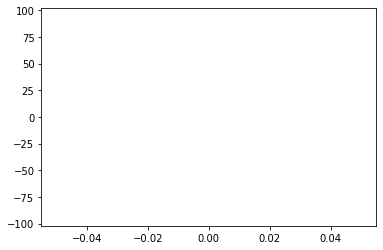

In [62]:
inter = samples_data[4, 1, :]

values = generate_inter(inter)

plt.plot(values)
plt.ylim(-102, 102)
plt.show()

In [61]:
# path 
path_to_runs = '.\\data\\general_summary_fit_inters.csv'
df_runs = pd.read_csv(path_to_runs)

df_runs['information_gained'] = (df_runs.prior_entropy - df_runs.posterior_entropy_unsmoothed) / df_runs.prior_entropy
print(df_runs.shape)

df_runs['experiment'] = df_runs['uid'].apply(lambda x: f'experiment_{x[0]}')

interventions['information_gained'] = np.nan

for i in df_runs.uid.unique():
    #if i[0] == '4':
        #print(df_runs.loc[df_runs.uid == i, 'information_gained'])
    #    print(interventions.loc[interventions.uiid == i])
    interventions.loc[interventions.uiid == i, 'information_gained'] = df_runs.loc[df_runs.uid == i, 'information_gained'].to_list()[0]

interventions['information_per_second'] = interventions.information_gained / interventions.length_sec

(14326, 14)


In [62]:
inter_db_path = '.\\data\\general_summary_fit_inters.obj'

with open(inter_db_path, 'rb') as inFile:
    inter_db = pickle.load(inFile)

In [63]:
interventions[interventions.experiment == 'experiment_2'].head()

,experiment,pid,utid,uiid,trial_type,trial,trial_idx,int_idx,var_inter_idx,variable,prior_type,gt_type,var_position,int_num,pos_in_trial,length,length_sec,relative_length,swipes,swipes10,abs_mean_idle,idle_freq,distance_travelled,min,max,avg,sd,mean_abs,std_abs,mode_abs,mode_abs_len,mode_abs_len_rel,range,relevant,num_inters,effect_1_label,effect_2_label,effect_1,effect_2,effect_1_prior,effect_2_prior,effect_1_estimate,effect_2_estimate,effect_1_error,effect_2_error,dataValid,inters,inters_real,error,accuracy,link_cases,link_cases_prior,prior_bf,log_length_sec,assignment,assignment_labels,assignment_labels_clean,information_gained,information_per_second
1724,experiment_2,59402f40e9b44100013b1789,2-59402f40e9b44100013b1789-crime_3-congruent,2-59402f40e9b44100013b1789-crime_3-congruent-2,congruent,crime_3,2,0,1,Population happiness,leaf,leaf,1,2,0.966887,2,0.4,0.006623,1.1,1,36.0,0.0,35,1,36,18.500000,17.500000,18.500000,17.500000,1,1,0.500000,35,1,2,Crime rate,Police action,0.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,1,3.5,3.5,2.0,2.0,1_no_link_&_1_link,1_no_link_&_1_link,NaN,-0.397940,2,short_1_swipe_&_no_hold,Single swipe,0.830142,2.075354
1725,experiment_2,59402f40e9b44100013b1789,2-59402f40e9b44100013b1789-crime_3-congruent,2-59402f40e9b44100013b1789-crime_3-congruent-1,congruent,crime_3,2,1,1,Crime rate,root,root,2,1,0.559603,2,0.4,0.006623,1.1,1,94.0,0.0,107,-13,94,40.500000,53.500000,53.500000,40.500000,13,1,0.500000,107,1,2,Police action,Population happiness,1.0,-0.5,1.0,-1.0,1.0,-1.0,0.0,0.5,1,3.5,3.5,0.5,3.5,2_links,2_links,NaN,-0.397940,2,short_1_swipe_&_no_hold,Single swipe,0.917598,2.293995
1726,experiment_2,59402f40e9b44100013b1789,2-59402f40e9b44100013b1789-estate_3-incongruent,2-59402f40e9b44100013b1789-estate_3-incongruent-2,incongruent,estate_3,2,0,1,Desirability,root,root,1,2,0.837748,2,0.4,0.006623,1.1,1,82.0,0.0,111,-29,82,26.500000,55.500000,55.500000,26.500000,29,1,0.500000,111,1,2,House Prices,Population Density,-1.0,1.0,0.5,1.0,0.5,1.0,1.5,0.0,1,3.5,3.5,1.5,2.5,2_links,2_links,NaN,-0.397940,2,short_1_swipe_&_no_hold,Single swipe,0.938744,2.346861
1727,experiment_2,59402f40e9b44100013b1789,2-59402f40e9b44100013b1789-estate_3-incongruent,2-59402f40e9b44100013b1789-estate_3-incongruent-1,incongruent,estate_3,2,1,1,House Prices,root,root,2,1,0.761589,3,0.6,0.009934,1.1,1,45.0,0.0,90,-45,45,8.333333,38.586123,38.333333,9.428090,45,2,0.666667,90,1,2,Desirability,Population Density,-1.0,-0.5,-0.5,-0.5,-0.5,-0.5,0.5,0.0,1,3.5,3.5,0.5,3.5,2_links,2_links,NaN,-0.221849,2,short_1_swipe_&_no_hold,Single swipe,0.998118,1.663530
1728,experiment_2,59402f40e9b44100013b1789,2-59402f40e9b44100013b1789-finance_3-implausible,2-59402f40e9b44100013b1789-finance_3-implausib...,implausible,finance_3,2,0,1,Lockdown Measures,root,root,0,2,0.605960,3,0.6,0.009934,1.1,1,57.0,0.0,49,8,57,28.000000,20.992062,28.000000,20.992062,8,1,0.333333,49,1,4,Stock Prices,Virus Cases,0.5,1.0,-1.0,-0.5,-0.5,-0.5,1.0,1.5,1,3.5,3.5,2.5,1.5,2_links,2_links,NaN,-0.221849,2,short_1_swipe_&_no_hold,Single swipe,0.787875,1.313125


In [64]:
print(inter_db[samples[0]]['normative_&_1'].keys())
print(inter_db[samples[0]]['normative_&_1']['ground_truth'])

# Determine indices of direct links and indirects links
inter_idx = 2
entropy_history = inter_db[samples[0]]['normative_&_1']['entropy_history']

def direct_and_indirect_links(inter_idx):
    if inter_idx == 2:
        directs = [4, 5]
        indirects = [0, 2]
    elif inter_idx == 1:
        directs = [2, 3]
        indirects = [1, 4]
    else:
        directs = [0, 1]
        indirects = [3, 5]

    return directs, indirects

def direct_and_indirect_link_labels(inter_idx, order_vars):
    if inter_idx == 2:
        directs = [
            f'{order_vars[2]} -> {order_vars[0]}',
            f'{order_vars[2]} -> {order_vars[1]}'
        ]
        indirects = [
            f'{order_vars[0]} -> {order_vars[1]}',
            f'{order_vars[1]} -> {order_vars[0]}'
        ]
    elif inter_idx == 1:
        directs = [
            f'{order_vars[1]} -> {order_vars[0]}',
            f'{order_vars[1]} -> {order_vars[2]}'
        ]
        indirects = [
            f'{order_vars[0]} -> {order_vars[2]}',
            f'{order_vars[2]} -> {order_vars[0]}'
        ]
    else:
        directs = [
            f'{order_vars[0]} -> {order_vars[1]}',
            f'{order_vars[0]} -> {order_vars[2]}'
        ]
        indirects = [
            f'{order_vars[1]} -> {order_vars[2]}',
            f'{order_vars[2]} -> {order_vars[1]}'
        ]

    return directs, indirects


directs, indirects = direct_and_indirect_links(inter_idx)

def get_entropies_of_links(directs, indirects, entropy_history):
    direct_entropies = entropy_history[:, directs]
    indirect_entropies = entropy_history[:, indirects]
    return direct_entropies, indirect_entropies

direct, indirect = get_entropies_of_links(directs, indirects, entropy_history)

def get_series_with_labels(inter_idx, entropy_history, order_vars):
    direct_link_idx, indirect_link_idx = direct_and_indirect_links(inter_idx)

    direct_link_labels, indirect_link_labels = direct_and_indirect_link_labels(inter_idx, order_vars)

    direct_entropies, indirect_entropies = get_entropies_of_links(direct_link_idx, indirect_link_idx, entropy_history)

    direct_series = {direct_link_labels[i]: direct_entropies[:, i] for i in range(2)}
    indirect_series = {indirect_link_labels[i]: indirect_entropies[:, i] for i in range(2)}
    
    return direct_series, indirect_series


#get_series_with_labels(inter_idx, entropy_history, order_vars)

dict_keys(['pid', 'trial_type', 'trial_name', 'ground_truth', 'posterior_map', 'posterior_judgement', 'prior_judgement', 'prior_entropy', 'posterior_entropy_unsmoothed', 'fitted_params', 'entropy_history', 'interventions', 'data', 'judgement_data'])
[ 0.  -0.5  0.5  0.5  0.5 -0.5]


In [65]:
print(inter_db[samples[0]]['normative_&_1']['entropy_history'])

[[2.32192809 2.32192809 2.32192809 2.32192809 2.32192809 2.32192809]
 [2.32192809 2.32192809 2.32192809 2.32192809 2.32192809 2.32192809]
 [2.04894584 2.04847597 2.32191988 2.31901513 2.32191988 2.31902116]
 [2.07411356 1.84148036 2.32191988 2.32083354 2.32191988 2.32149643]
 [1.84202668 1.91302893 2.32191988 2.31896809 2.32191988 2.32031765]
 [1.87944375 1.13631724 2.32191988 2.30335046 2.32191988 2.3213235 ]]


In [66]:
exp.df_trials.head()

,experiment,pid,utid,trial_type,trial_name,trial_spec,accuracy,hamming,num_indirect_errors,num_indirect_links,priorTruth,priorISpost,cond_label,cond,cond_order,genCorr,posCorr,negCorr,weakCorr,stgCorr,weakPosCorr,stgPosCorr,weakNegCorr,stgNegCorr,nullCorr,nonNullCorr,inters,inters_real,sense,expect,variables,std_order,postOriginOrder,num_inter,intervened_time
1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0,generic_0,ccause,None,0.878732,1.0,0,0,NaN,NaN,NaN,0,NaN,0.666667,1.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause_effect1_effect2,Blue_Red_Green,5.0,0.523179
1-56da8da8c5b248000ae2adaf-collider_2-generic_1,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-collider_2-generic_1,generic_1,collider,None,0.636197,0.666667,0,0,NaN,NaN,NaN,0,NaN,0.666667,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause1_cause2_effect,Blue_Red_Green,4.0,0.662252
1-56da8da8c5b248000ae2adaf-crime_4-label,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-crime_4-label,label,crime,None,0.860427,0.833333,1,2,0.377964,False,NaN,0,NaN,0.5,1.0,0.666667,0.5,0.0,NaN,0.0,0.5,0.0,1.0,0.75,NaN,NaN,3,It makes sense that Some variables influenece ...,NaN,Police action_Crime rate_Population happiness,Police action_Crime rate_Population happiness,4.0,0.466887
1-56da8da8c5b248000ae2adaf-pos_chain_3-generic_2,experiment_1,56da8da8c5b248000ae2adaf,1-56da8da8c5b248000ae2adaf-pos_chain_3-generic_2,generic_2,chain,pos,0.851478,0.666667,1,1,NaN,NaN,NaN,0,NaN,0.5,1.0,NaN,NaN,0.5,NaN,0.5,NaN,NaN,0.5,1.0,NaN,NaN,NaN,NaN,NaN,one_two_three,Blue_Red_Green,4.0,0.688742
1-57e91ff08dcd2c00014bea18-ccause_2-generic_0,experiment_1,57e91ff08dcd2c00014bea18,1-57e91ff08dcd2c00014bea18-ccause_2-generic_0,generic_0,ccause,None,0.878732,1.0,0,0,NaN,NaN,NaN,1,NaN,0.666667,1.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,cause_effect1_effect2,Blue_Red_Green,7.0,0.400662


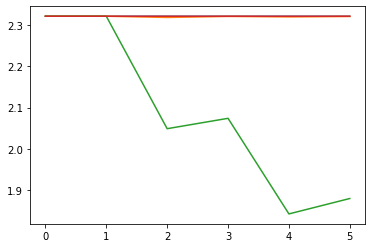

In [67]:
plt.plot(direct)
plt.plot(indirect)

plt.show()

In [68]:

def plot_intervention(node_name, inter_data, order_vars, ax):
    nodes = order_vars

    data = np.array([inter_data[node] for node in nodes])

    K = len(nodes)
    int_idx = nodes.index(node_name)

    palette = sns.color_palette() # Set palette
    sns.set_palette(palette)

    for k in range(K):
        sns.lineplot(data=data[k, :], lw=1.5, label=nodes[k], ax=ax)


    x = np.arange(data.shape[1])
    y1 = -100 * np.ones(data.shape[1])
    y2 = 100 * np.ones(data.shape[1])

    ax.fill_between(x, y1, y2, color=palette[int_idx], alpha=0.15)

    #ax.legend(prop={'size': 6})

    return int_idx

def plot_links(series, direct, ax):
    data = pd.DataFrame(series)

    if direct:
        colors = {data.columns[i]:sns.color_palette('Paired')[i+4] for i in range(2)}
        #linestyle = ('solid', 'solid')
        dashes = {data.columns[i]:'' for i in range(2)}
    else:
        colors = {data.columns[i]:sns.color_palette('Paired')[i+8] for i in range(2)}
        #linestyle = ('--', '--')
        dashes =  {data.columns[i]:(1,1) for i in range(2)}

    sns.lineplot(data=data, lw=1.5, ax=ax, palette=colors, dashes=dashes)

    #ax.legend(prop={'size': 6})
    


Components: ['noise', 'short_1_swipe_&_no_hold', 'med_23_swipes_&_med_hold', 'long_1_swipe_&_long_hold', 'long_double_swipes_&_long_hold', 'long_multi_swipes_&_med_hold']


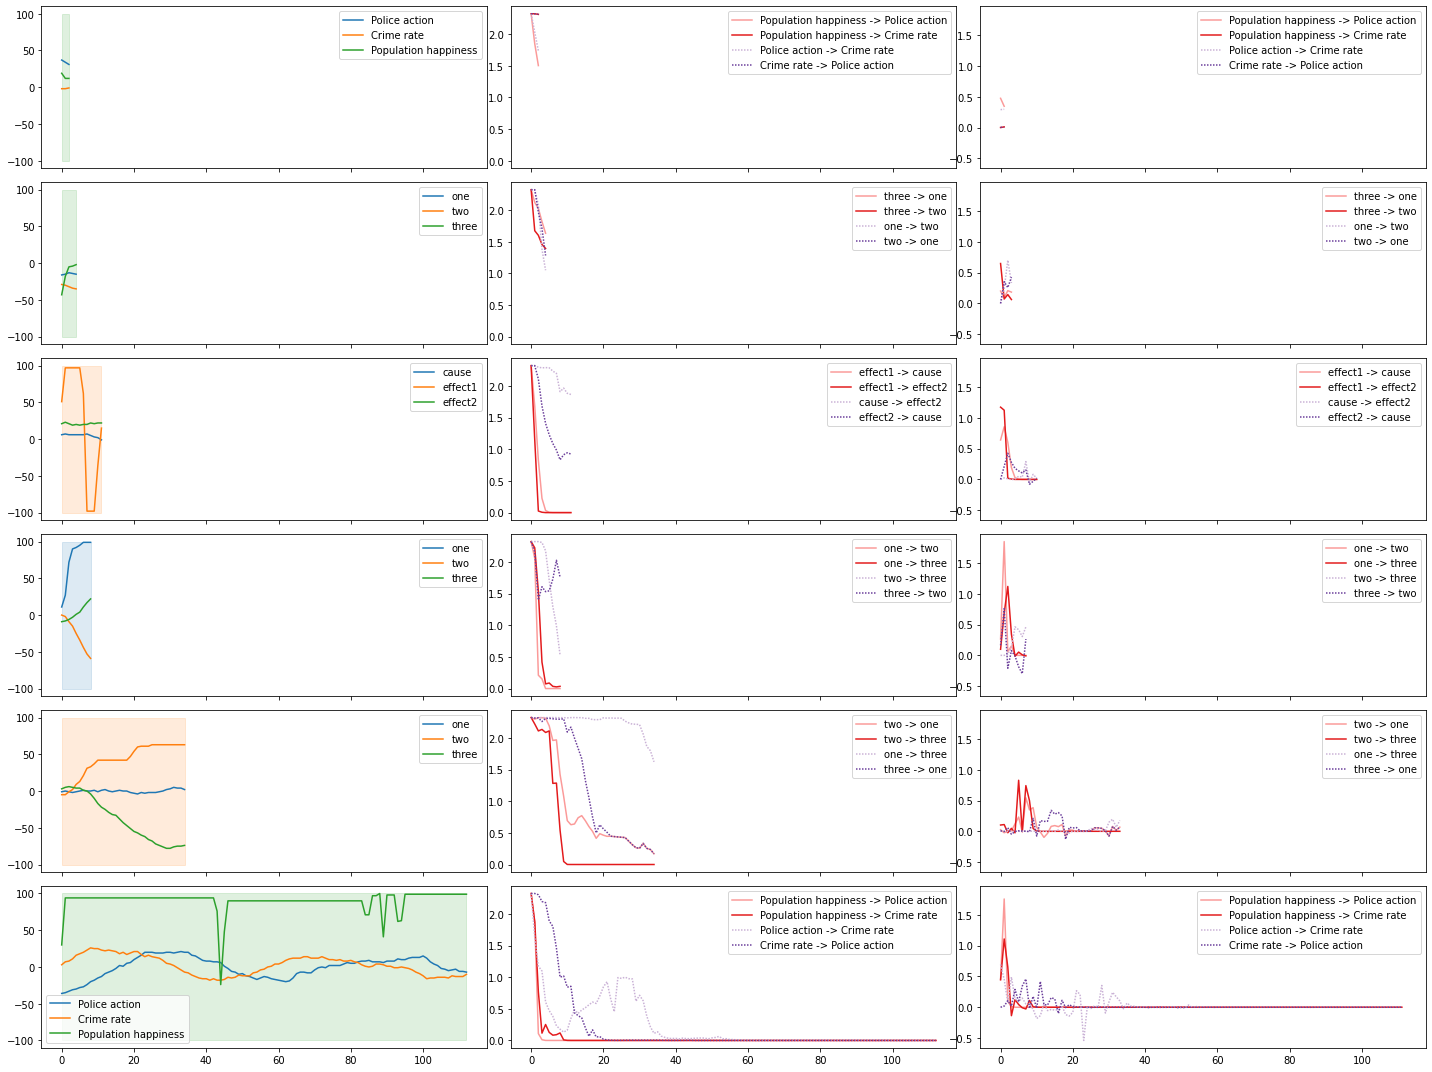

In [69]:
sample_size = 1

int_indices = np.zeros((len(assign_order), sample_size))
num_rows = len(components_labels)


fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15), sharex=True, sharey='col')

samples_data = np.zeros((num_rows, num_cols, 4))
print(f'Components: {[labels[i] for i in assign_order]}')
for i, assign in enumerate(assign_order):

    samples = np.random.choice(interventions[interventions.assignment_labels == labels[assign]].uiid.to_list(), size=sample_size, replace=False)

    
    for j in range(sample_size):
        #print(samples[j][:-2])
        #print(samples[j][:-(1 + len(samples[j].split('-')[-1]))])
        order_vars = exp.df_trials[exp.df_trials.utid == samples[j][:-(1 + len(samples[j].split('-')[-1]))]].std_order[0].split('_')
        
        #print(order_vars)
    
        s_data = interventions.loc[interventions.uiid == samples[j], cols]
        samples_data[i, j, :] = s_data.loc[s_data.index[0]].to_list()
        
        inter = exp.inters_db[samples[j]]
        #print(inter['length_sec'], inter['mode_abs'], inter['swipes10'], inter['mode_abs_len_rel'])
        int_indices[i, j] = plot_intervention(inter['variable'], inter['values'], order_vars, axs[i, j])
        #axs[i, j].legend(bbox_to_anchor=(1.1, 1.05))
        #print(inter['swipes'])

        len_data = len(inter['values'][list(inter['values'])[0]])
        entropy_history = inter_db[samples[j]]['normative_&_1']['entropy_history'][1:len_data+1,:]

        info_gain = (entropy_history[:-1, :] - entropy_history[1:, :])#/ inter_db[samples[j]]['normative_&_1']['entropy_history'][:-1, :]

        direct_series, indirect_series = get_series_with_labels(int_indices[i, j], entropy_history, order_vars)

        plot_links(direct_series, True, axs[i, j+1])
        plot_links(indirect_series, False, axs[i, j+1])

        direct_series, indirect_series = get_series_with_labels(int_indices[i, j], info_gain, order_vars)

        plot_links(direct_series, True, axs[i, j+2])
        plot_links(indirect_series, False, axs[i, j+2])


plt.tight_layout()
plt.show()

In [70]:
direct_series

{'Population happiness -> Police action': array([ 0.45548672,  1.75823315,  0.09644491,  0.01127207,  0.00027172,
         0.00017623, -0.00002911, -0.00006413, -0.00001633, -0.00001941,
        -0.00001267, -0.00006109,  0.00001292,  0.00000256, -0.00003218,
        -0.00014552,  0.00034713, -0.00005151,  0.00006623, -0.0000554 ,
        -0.00002171, -0.00002888, -0.00038593,  0.0004571 ,  0.00006328,
         0.00001697,  0.00000086,  0.0000001 ,  0.00000001,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0

In [71]:
inter_db[samples[j]]['normative_&_1'].keys()

dict_keys(['pid', 'trial_type', 'trial_name', 'ground_truth', 'posterior_map', 'posterior_judgement', 'prior_judgement', 'prior_entropy', 'posterior_entropy_unsmoothed', 'fitted_params', 'entropy_history', 'interventions', 'data', 'judgement_data'])

In [77]:
df_runs.head()

,uid,participant,trial_type,trial_name,model_name,ground_truth,posterior_map,posterior_judgement,prior_judgement,prior_entropy,posterior_entropy_unsmoothed,posterior_entropy,model_specs,information_gained,experiment
0,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0-1,56da8da8c5b248000ae2adaf,generic_0,ccause,normative_&_1,[1 1 0 0 0 0],[ 1. 1. 0.5 -0.5 0. 0. ],NaN,NaN,13.931569,5.477749,13.922202,NaN,0.606810,experiment_1
1,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0-2,56da8da8c5b248000ae2adaf,generic_0,ccause,normative_&_1,[1 1 0 0 0 0],[ 1. -1. 0. 1. 0. -0.5],NaN,NaN,13.931569,9.037416,13.931259,NaN,0.351299,experiment_1
2,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0-3,56da8da8c5b248000ae2adaf,generic_0,ccause,normative_&_1,[1 1 0 0 0 0],[-1. 1. 0. 0. 0. 0.],NaN,NaN,13.931569,5.768224,13.925373,NaN,0.585960,experiment_1
3,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0-4,56da8da8c5b248000ae2adaf,generic_0,ccause,normative_&_1,[1 1 0 0 0 0],[ 1. 1. 0.5 0. -1. 0. ],NaN,NaN,13.931569,2.603288,4.852870,NaN,0.813137,experiment_1
4,1-56da8da8c5b248000ae2adaf-ccause_3-generic_0-5,56da8da8c5b248000ae2adaf,generic_0,ccause,normative_&_1,[1 1 0 0 0 0],[ 0.5 0.5 0. -0.5 -1. -0.5],NaN,NaN,13.931569,5.002402,13.810067,NaN,0.640930,experiment_1


### Accuracy and information gained from the intervention type

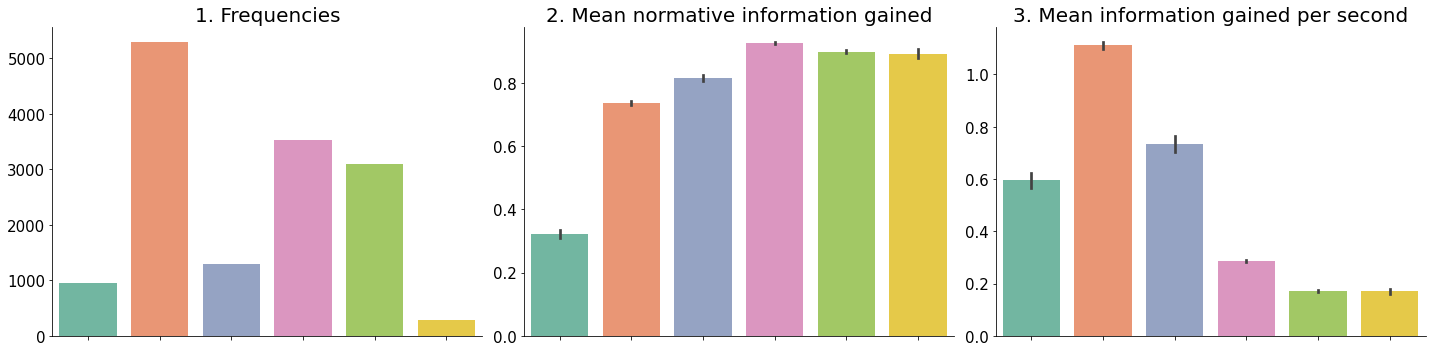

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='assignment_labels_clean', data=interventions, ax=axs[0], order=assign_label_order_clean, palette=assign_label_colors_clean)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right', fontsize=12)
axs[0].set_xticklabels([], rotation=45, ha='right', fontsize=12)
ticks_loc = axs[0].get_yticks().tolist()
axs[0].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axs[0].set_yticklabels([int(x) for x in ticks_loc], fontsize=15)
axs[0].set_title('1. Frequencies', fontsize=20)
axs[0].set_xlabel('')
axs[0].set_ylabel('')

#sns.barplot(x='assignment_labels', y='accuracy', data=interventions, ax=axs[1], order=assign_label_order, palette=assign_label_colors)
#axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
#axs[1].set_title('Mean accuracy for each type')
#axs[1].set_ylim(2.5, 3.6)
#axs[1].set_xlabel('')

sns.barplot(x='assignment_labels_clean', y='information_gained', data=interventions, ax=axs[1], order=assign_label_order_clean, palette=assign_label_colors_clean, ci=95)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)
axs[1].set_xticklabels([], rotation=45, ha='right', fontsize=12)
ticks_loc = axs[1].get_yticks().tolist()
axs[1].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axs[1].set_yticklabels([np.round(x, 1) for x in ticks_loc], fontsize=15)
axs[1].set_title('2. Mean normative information gained', fontsize=20)
axs[1].set_xlabel('')
axs[1].set_ylabel('')

sns.barplot(x='assignment_labels_clean', y='information_per_second', data=interventions, ax=axs[2], order=assign_label_order_clean, palette=assign_label_colors_clean, ci=95)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right', fontsize=12)
axs[2].set_xticklabels([], rotation=45, ha='right', fontsize=12)
ticks_loc = axs[2].get_yticks().tolist()
axs[2].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
axs[2].set_yticklabels([np.round(x, 1) for x in ticks_loc], fontsize=15)
axs[2].set_title('3. Mean information gained per second', fontsize=20)
axs[2].set_xlabel('')
axs[2].set_ylabel('')

sns.despine()

plt.tight_layout()
plt.show()

[0.06542056 0.36656282 0.08930426 0.2445829  0.21467636 0.0194531 ]


ValueError: The internally computed table of expected frequencies has a zero element at (2, 0).

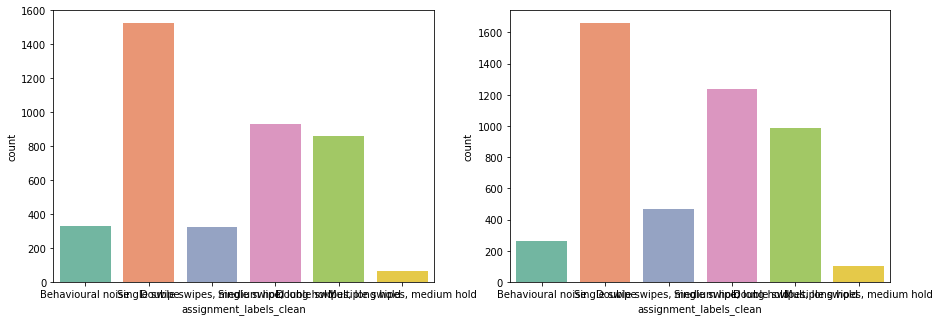

In [422]:

freq_table_exp = np.zeros((4, len(assign_label_order_clean)))

gen_freq = np.zeros(len(assign_label_order_clean))
gen_freq[:] = interventions.assignment_labels_clean.value_counts(normalize=True)[assign_label_order_clean]

fig, axs = plt.subplots(1, len(experiments), figsize=(15, 5))

freq_exp_gen = np.zeros((4, len(assign_label_order_clean)))
for i, experiment in enumerate(experiments):
    inter_exp = interventions[interventions.experiment == experiment]
    freq_table_exp[i, :] = inter_exp.assignment_labels_clean.value_counts()[assign_label_order_clean]
    freq_exp_gen[i, :] = gen_freq * inter_exp.shape[0]

    sns.countplot(x='assignment_labels_clean', data=inter_exp, ax=axs[i], order=assign_label_order_clean, palette=assign_label_colors_clean)



print(gen_freq)
print(stats.chi2_contingency(freq_table_exp)[:2])
print(stats.chisquare(freq_table_exp, freq_exp_gen))

plt.show()

#### Takeaways:

- The most performed intervention is the simple swipe to a high absolute value. It is also the most efficient intervention in terms of information gained per second spent intervening.
- The previous fact explains why normatively, an agent attempting to maximise its information
- 1 swipe and a long hold, the second most performed intervention is in general the most informative interventions, despite not being the longest. They are also the most efficient of the long interventions.

Num interventions congruent: 1926
Num interventions incongruent: 1834


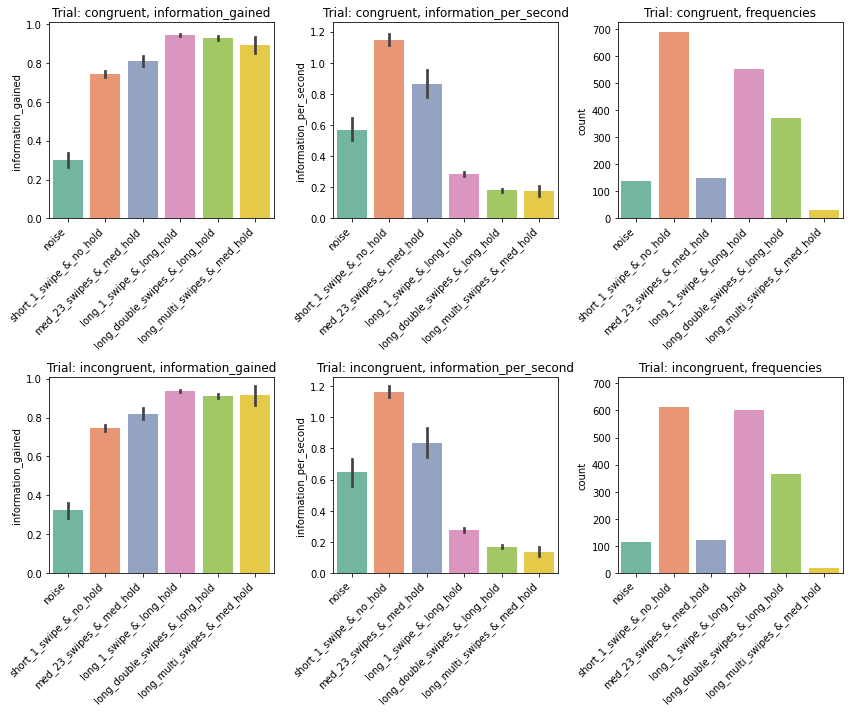

In [423]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

dims = ['information_gained', 'information_per_second', 'frequencies']

fig, axs = plt.subplots(len(trials_diff), len(dims), figsize=(12, 10), sharey='col')


for i, t_d in enumerate(trials_diff):
    df_plot = inter_34[inter_34.trial_type == t_d]
    print(f'Num interventions {t_d}: {len(df_plot)}')
    for j, dim in enumerate(dims):

        if j < len(dims) - 1:
            sns.barplot(x='assignment_labels', y=dims[j], data=df_plot, ax=axs[i, j], order=assign_label_order, palette=assign_label_colors)
        else:
            sns.countplot(x='assignment_labels', data=df_plot, ax=axs[i, j], order=assign_label_order, palette=assign_label_colors)
        
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45, ha='right')
        axs[i, j].set_title(f'Trial: {t_d}, {dim}')
        axs[i, j].set_xlabel('')

plt.tight_layout()
plt.show()

In [336]:
inter_34.columns

Index(['experiment', 'pid', 'utid', 'uiid', 'trial_type', 'trial', 'trial_idx',
       'int_idx', 'var_inter_idx', 'variable', 'prior_type', 'gt_type',
       'var_position', 'int_num', 'pos_in_trial', 'length', 'length_sec',
       'relative_length', 'swipes', 'swipes10', 'abs_mean_idle', 'idle_freq',
       'distance_travelled', 'min', 'max', 'avg', 'sd', 'mean_abs', 'std_abs',
       'mode_abs', 'mode_abs_len', 'mode_abs_len_rel', 'range', 'relevant',
       'num_inters', 'effect_1_label', 'effect_2_label', 'effect_1',
       'effect_2', 'effect_1_prior', 'effect_2_prior', 'effect_1_estimate',
       'effect_2_estimate', 'effect_1_error', 'effect_2_error', 'dataValid',
       'inters', 'inters_real', 'error', 'accuracy', 'link_cases',
       'link_cases_prior', 'prior_bf', 'log_length_sec', 'assignment',
       'assignment_labels', 'assignment_labels_clean', 'information_gained',
       'information_per_second'],
      dtype='object')

In [340]:
df_34_labelled.experiment.unique()

array(['experiment_3', 'experiment_4'], dtype=object)

C:\Users\vbtes\AppData\Local\Temp/ipykernel_27484/1311629607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_34_labelled['prior_diff'] = df_34_labelled.trial_type + '_' + df_34_labelled.prior_bf.astype(str)


F_onewayResult(statistic=8.199512651752318, pvalue=2.0164499504627753e-05)
F_onewayResult(statistic=1.1584657235818179, pvalue=0.324275712556215)


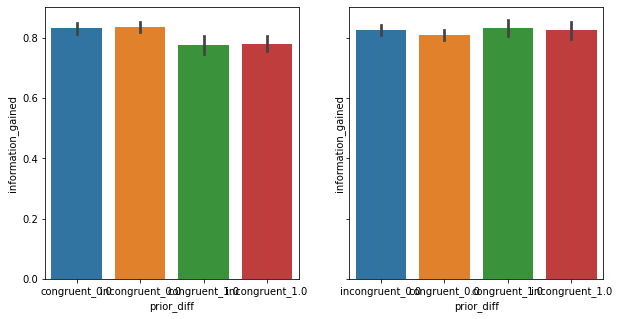

In [437]:
df_34_labelled = inter_34[inter_34.trial_type.isin(trials_diff)]

df_34_labelled['prior_diff'] = df_34_labelled.trial_type + '_' + df_34_labelled.prior_bf.astype(str)

df_34_g = df_34_labelled[~df_34_labelled.prior_diff.isin(['congruent_nan', 'incongruent_nan'])]

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

experiments = ['experiment_3', 'experiment_4']

for i, experiment in enumerate(experiments):
    df_exp = df_34_g[df_34_g.experiment == experiment]

    groups = []
    for j, t_d in enumerate(df_exp.prior_diff.unique()):
        groups.append(df_exp[df_exp.prior_diff == t_d].information_gained.to_list())
    print(stats.f_oneway(*groups))
    sns.barplot(x='prior_diff', y='information_gained', data=df_exp, ax=axs[i])




NameError: name 'link_cases' is not defined

In [448]:
df_exp.link_cases.unique()

array(['1_no_link_&_1_link', '2_links', '2_no_link'], dtype=object)

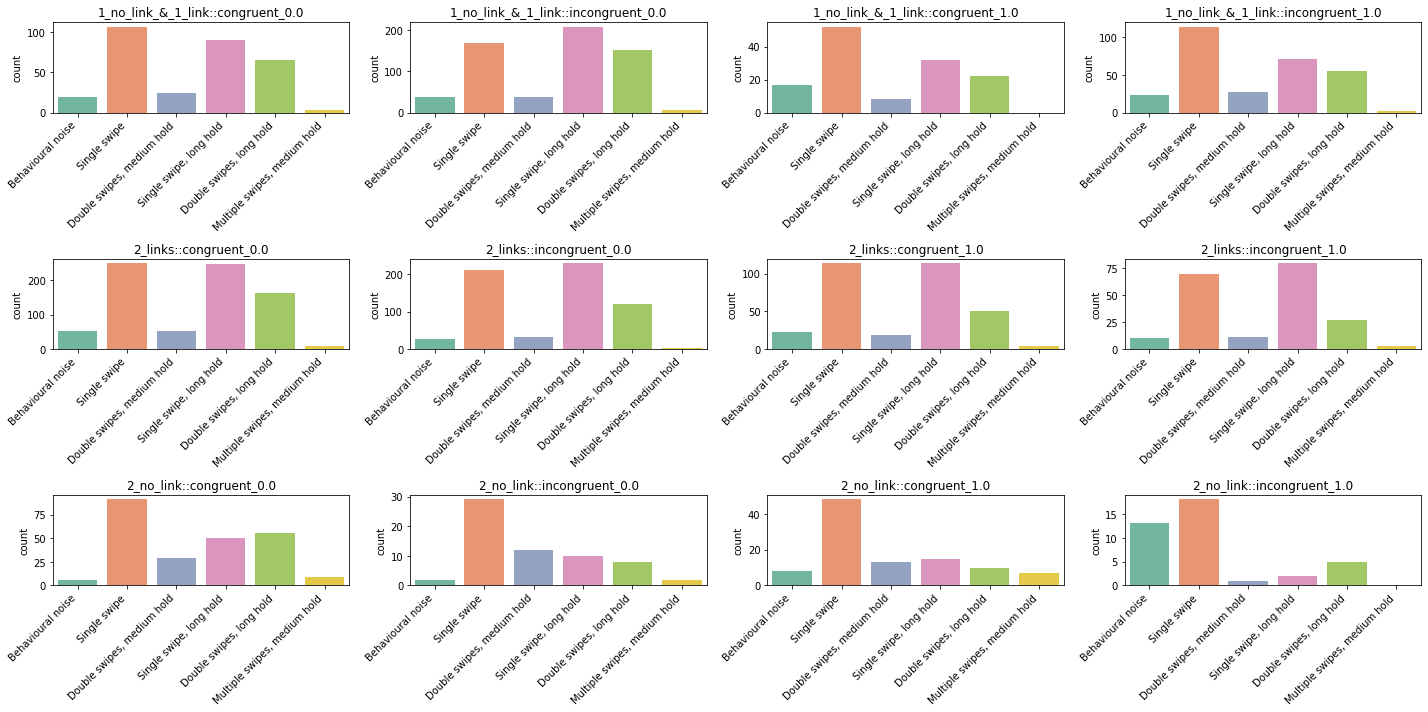

In [451]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))

experiments = ['experiment_3', 'experiment_4']
link_cases = ['1_no_link_&_1_link', '2_links', '2_no_link']
diff_conds = df_34_g.prior_diff.unique()
for i, link_case in enumerate(['1_no_link_&_1_link', '2_links', '2_no_link']):
    #df_exp = df_34_g[df_34_g.experiment == experiment]
    df_exp = df_34_g[df_34_g.link_cases == link_case]

    for j, t_d in enumerate(diff_conds):
        df_g = df_exp[df_exp.prior_diff == t_d]
        sns.countplot(x='assignment_labels_clean', data=df_g, ax=axs[i, j], palette=assign_label_colors_clean, order=assign_label_order_clean)
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45, ha='right')
        axs[i, j].set_title(f'{link_case}::{t_d}')
        axs[i, j].set_xlabel('')

plt.tight_layout()

congruent_0.0      1320
incongruent_0.0    1297
congruent_1.0       557
incongruent_1.0     534
congruent_nan        49
incongruent_nan       3
Name: prior_diff, dtype: int64

In [464]:
model = ols('information_gained ~ C(prior_bf) * C(trial_type) ', data=df_34_labelled[df_34_labelled.experiment == 'experiment_3']).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(prior_bf),1.224636,1.0,24.514419,8.035501e-07
C(trial_type),0.006408,1.0,0.128269,7.202739e-01
C(prior_bf):C(trial_type),0.000169,1.0,0.003388,9.535881e-01
Residual,93.816880,1878.0,NaN,NaN


### Simple effect of condition on intervention type frequencies

[0.06755319 0.34654255 0.0712766  0.30611702 0.19574468 0.01276596]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (3).

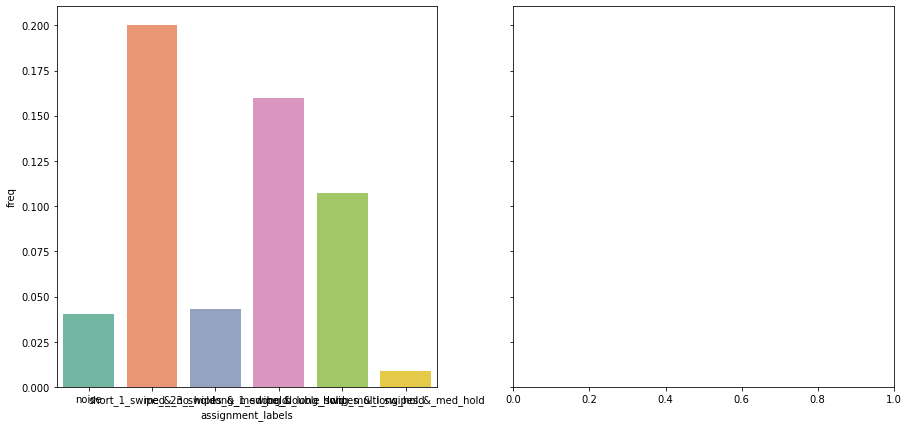

In [334]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]


trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34[inter_34.trial_type.isin(trials_diff)]


gen_freq = np.zeros(interventions.assignment_labels.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = inter_34_prior[inter_34_prior.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()

print(gen_freq)

fig, axs = plt.subplots(1, len(trials_diff), figsize=(15, 7), sharey=True)

condition_freqs = np.zeros((len(trials_diff), len(assign_label_order)))
exp_freqs = np.zeros((len(trials_diff), len(assign_label_order)))

for i, diff in enumerate(trials_diff):
    df_diff = inter_34_prior[inter_34_prior.trial_type == diff]
    #exp_freqs[i, :] = df_diff.assignment_labels.size * gen_freq

    df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
    for j, int_type in enumerate(assign_label_order):
        condition_freqs[i, j] = df_diff[df_diff.assignment_labels == int_type].shape[0]
        exp_freqs[i, j] = df_diff.assignment_labels.size * gen_freq[j]
        df_plot2.loc[df_plot2.index.size] = [int_type, condition_freqs[i, j] / df_plot.assignment_labels.size]

    sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[i], order=assign_label_order, palette=assign_label_colors)
    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Condition: {diff}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')



In [35]:
chi2, p, _, _ = stats.chi2_contingency(condition_freqs)
print('Contigency')
print(chi2, p)

print('Intervention type:')
chi2, p = stats.chisquare(condition_freqs, exp_freqs)
print(chi2)
print(p)

Contigency
13.615680458397978 0.018244071056619002
Intervention type:
[1.246061   1.42769224 1.71663626 5.44786931 0.3484048  3.42901684]
[0.26430614 0.23214144 0.19012661 0.01959221 0.55501753 0.06406023]


What seems to happen (marginally) is that in incongruent trials, participants do a little less short 1 swipes, and more long 1 swipes, perhaps needing more time to unlearn and gather evidence for the incongruent ground truth.

Sanity check that information gained correctly depends on the length of interventions

Pearson R: 0.4325727875035227, p=1.2663916283354597e-25


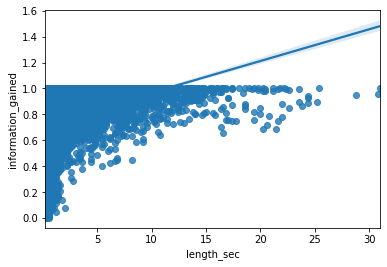

In [333]:
clean_int = interventions.dropna()
r, p = stats.pearsonr(clean_int.length_sec, clean_int.information_gained)
print(f'Pearson R: {r}, p={p}')
sns.regplot(x='length_sec', y='information_gained', data=interventions)
plt.show()

### Looking at the frequency of types for different links (no link, link)

As there are always two outgoing links, there are three cases: 2 no links, 1 no link & 1 link and 2 links 

Distribution of links cases: [0.24835033 0.39912018 0.35252949]
Distribution of interventions number per links cases: [0.23800623 0.39418484 0.36780893]


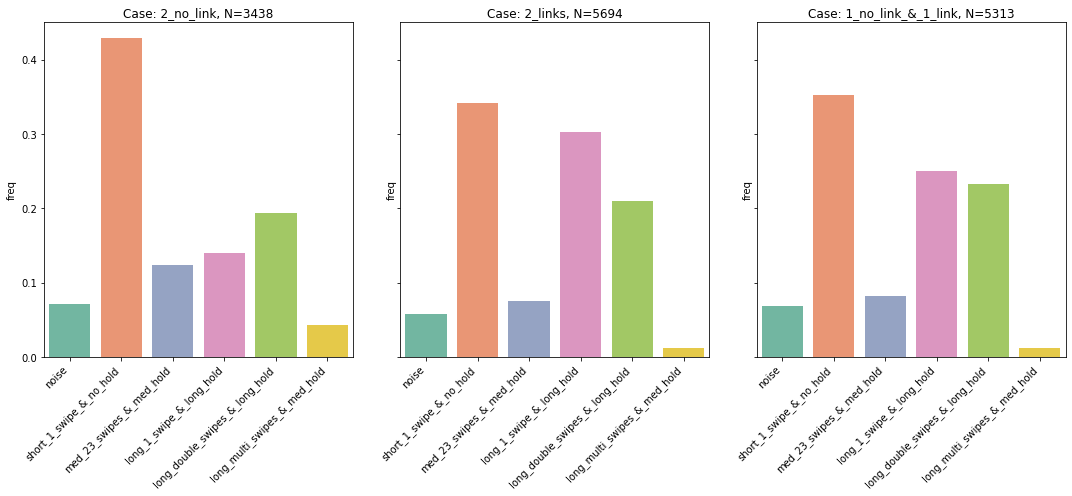

In [454]:
num_cols = len(interventions.link_cases.unique())

freq_data = np.zeros((num_cols, interventions.assignment_labels.unique().size))
freq_exp = np.zeros((num_cols, interventions.assignment_labels.unique().size))
gen_freq = np.zeros(interventions.assignment_labels.unique().size)

freq_int_link_cases = np.zeros(interventions.link_cases.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = interventions[interventions.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()

fig, axs = plt.subplots(1, num_cols, figsize=(15, 7), sharey=True)

for i, case in enumerate(interventions.link_cases.unique()):

    df_plot = interventions[interventions.link_cases == case]

    freq_int_link_cases[i] = df_plot.shape[0]
    
    df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
    for j, int_type in enumerate(assign_label_order):
        #print(int_type)
        freq_data[i, j] = df_plot[df_plot.assignment_labels == int_type].shape[0]
        freq_exp[i, j] = df_plot.assignment_labels.size * gen_freq[j]
        df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j] / df_plot.assignment_labels.size]


    #print(df_plot.assignment_labels.value_counts(sort=False))
    #sns.countplot(x='assignment_labels', data=df_plot, ax=axs[i], order=interventions.assignment_labels.unique())
    sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[i], order=assign_label_order, palette=assign_label_colors)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Case: {case}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')


print(f'Distribution of links cases: {links_cases_freq / links_cases_freq.sum()}')
print(f'Distribution of interventions number per links cases: {freq_int_link_cases / freq_int_link_cases.sum()}')


plt.tight_layout()
plt.show()


In [455]:

print('Chi-square test:')
print(freq_data.astype(int))
print(f'N={freq_data.sum()}')
chi2, p, dof, ex = stats.chi2_contingency(freq_data)
print(f'Chi-square: {np.round(chi2, 2)}, P-value:{np.round(p, 4)}')

print('\nType-wise Chi-square tests')
print(f'N={freq_data.sum(axis=0)}')
chi2, p = stats.chisquare(freq_data, freq_exp)
print(f'Interventions:\n{assign_label_order}\nChisquare:\n{np.round(chi2, 2)}\n P-values:\n{np.round(p, 4)}')

Chi-square test:
[[ 245 1474  424  481  668  146]
 [ 333 1947  428 1721 1196   69]
 [ 367 1874  438 1331 1237   66]]
N=14445.0
Chi-square: 486.05, P-value:0.0

Type-wise Chi-square tests
N=[ 945. 5295. 1290. 3533. 3101.  281.]
Interventions:
['noise', 'short_1_swipe_&_no_hold', 'med_23_swipes_&_med_hold', 'long_1_swipe_&_long_hold', 'long_double_swipes_&_long_hold', 'long_multi_swipes_&_med_hold']
Chisquare:
[  7.07  48.45  60.11 232.2   15.37 122.85]
 P-values:
[0.0292 0.     0.     0.     0.0005 0.    ]


Distribution of links cases: [0.24835033 0.39912018 0.35252949]
Distribution of interventions number per links cases: [0.175      0.59015957 0.23484043]


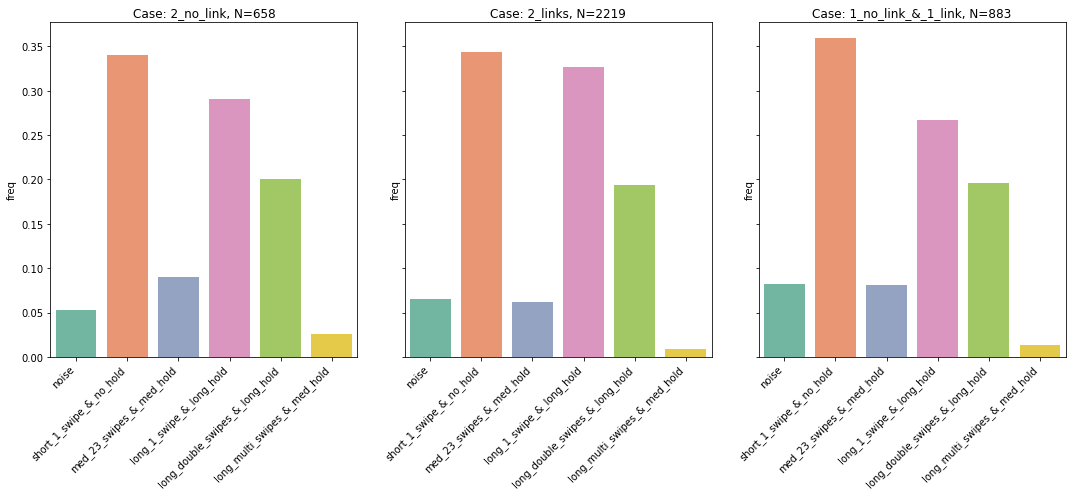

In [457]:

inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34[inter_34.trial_type.isin(trials_diff)]


num_cols = len(interventions.link_cases.unique())

freq_data = np.zeros((num_cols, interventions.assignment_labels.unique().size))
freq_exp = np.zeros((num_cols, interventions.assignment_labels.unique().size))
gen_freq = np.zeros(interventions.assignment_labels.unique().size)

freq_int_link_cases = np.zeros(interventions.link_cases.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = inter_34_prior[inter_34_prior.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()

fig, axs = plt.subplots(1, num_cols, figsize=(15, 7), sharey=True)

for i, case in enumerate(interventions.link_cases.unique()):

    df_p = inter_34_prior[inter_34_prior.link_cases_prior == case]
    df_plot = df_p#[df_p.var_inter_idx == 1]

    freq_int_link_cases[i] = df_plot.shape[0]
    
    df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
    for j, int_type in enumerate(assign_label_order):
        #print(int_type)
        freq_data[i, j] = df_plot[df_plot.assignment_labels == int_type].shape[0]
        freq_exp[i, j] = df_plot.assignment_labels.size * gen_freq[j]
        df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j] / df_plot.assignment_labels.size]


    #print(df_plot.assignment_labels.value_counts(sort=False))
    #sns.countplot(x='assignment_labels', data=df_plot, ax=axs[i], order=interventions.assignment_labels.unique())
    sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[i], order=assign_label_order, palette=assign_label_colors)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Case: {case}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')


print(f'Distribution of links cases: {links_cases_freq / links_cases_freq.sum()}')
print(f'Distribution of interventions number per links cases: {freq_int_link_cases / freq_int_link_cases.sum()}')


plt.tight_layout()
plt.show()

In [458]:

print('Chi-square test:')
print(freq_data.astype(int))
chi2, p, dof, ex = stats.chi2_contingency(freq_data)
print(f'Chi-square: {np.round(chi2, 2)}, P-value:{np.round(p, 4)}')

print('\nType-wise Chi-square tests')
chi2, p = stats.chisquare(freq_data, freq_exp)
print(f'Interventions:\n{assign_label_order}\nChisquare:\n{np.round(chi2, 2)}\n P-values:\n{np.round(p, 4)}')

Chi-square test:
[[ 35 224  59 191 132  17]
 [146 762 137 724 431  19]
 [ 73 317  72 236 173  12]]
Chi-square: 32.75, P-value:0.0003

Type-wise Chi-square tests
Interventions:
['noise', 'short_1_swipe_&_no_hold', 'med_23_swipes_&_med_hold', 'long_1_swipe_&_long_hold', 'long_double_swipes_&_long_hold', 'long_multi_swipes_&_med_hold']
Chisquare:
[ 5.1   0.53  7.26  7.84  0.11 11.92]
 P-values:
[0.0781 0.7672 0.0265 0.0199 0.9486 0.0026]


In [459]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34[inter_34.trial_type.isin(trials_diff)]

indices = np.arange(1, 5)

def generate_frequencies_indices(df, prior_or_gt):

    num_cols = len(interventions.link_cases.unique())

    indices = np.arange(1, 5)

    freq_data = np.zeros((len(indices), num_cols, df.assignment_labels.unique().size))
    freq_exp = np.zeros((len(indices), num_cols, df.assignment_labels.unique().size))
    gen_freq = np.zeros((len(indices), df.assignment_labels.unique().size))

    freq_int_link_cases = np.zeros((len(indices), df.link_cases.unique().size))

    for i, idx in enumerate(indices):
        df_idx = df[df.var_inter_idx == idx]

        for j, int_type in enumerate(assign_label_order):
            gen_freq[i, j] = df_idx[df_idx.assignment_labels == int_type].assignment_labels.count()

        gen_freq[i, :] = gen_freq[i, :] / gen_freq[i, :].sum()

    for i, idx in enumerate(indices):
        df_idx = df[df.var_inter_idx == idx]

        for j, case in enumerate(interventions.link_cases.unique()):

        
            if prior_or_gt:
                df_p = df_idx[df_idx.link_cases_prior == case]
            else:
                df_p = df_idx[df_idx.link_cases == case]
            df_plot = df_p#[df_p.var_inter_idx == 1]

            freq_int_link_cases[i, j] = df_plot.shape[0]
    
            df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
            for k, int_type in enumerate(assign_label_order):
                #print(int_type)
            

                freq_data[i, j, k] = df_plot[df_plot.assignment_labels == int_type].shape[0]
                freq_exp[i, j, k] = df_plot.assignment_labels.size * gen_freq[i, k]
                df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j, k] / df_plot.assignment_labels.size]

    return freq_data, freq_exp


freq_data_prior, freq_exp_prior = generate_frequencies_indices(inter_34_prior, True)
freq_data_gt, freq_exp_gt = generate_frequencies_indices(inter_34_prior, False)

# Do for prior bf
# Prior bf == 0
df_34_prior_0 = inter_34_prior[inter_34_prior.prior_bf == 0]
freq_data_prior_0, freq_exp_prior_0 = generate_frequencies_indices(df_34_prior_0, True)
freq_data_gt_0, freq_exp_gt_0 = generate_frequencies_indices(df_34_prior_0, False)
# Prior bf == 1
df_34_prior_1 = inter_34_prior[inter_34_prior.prior_bf == 1]
freq_data_prior_1, freq_exp_prior_1 = generate_frequencies_indices(df_34_prior_1, True)
freq_data_gt_1, freq_exp_gt_1 = generate_frequencies_indices(df_34_prior_1, False)


In [460]:

chi2_contingency_prior = np.zeros((len(indices), 2))
chi2_contingency_gt =  np.zeros((len(indices), 2))

chi2_contingency_prior_bf = np.zeros((len(indices), 2, 2))
chi2_contingency_gt_bf = np.zeros((len(indices), 2, 2))

chi2s_prior = np.zeros((len(indices), len(assign_label_order), 2))
chi2s_gt = np.zeros((len(indices), len(assign_label_order), 2))
 
for i in range(freq_data.shape[0]):
    chi2_contingency_prior[i, :] = stats.chi2_contingency(freq_data_prior[i, :, :])[:2]
    chi2_contingency_gt[i, :] = stats.chi2_contingency(freq_data_gt[i, :, :])[:2]

    chi2_contingency_prior_bf[i, 0, :] = stats.chi2_contingency(freq_data_prior_0[i, :, :])[:2]
    chi2_contingency_prior_bf[i, 1, :] = stats.chi2_contingency(freq_data_prior_1[i, :, :])[:2]

    chi2_contingency_gt_bf[i, 0, :] = stats.chi2_contingency(freq_data_gt_0[i, :, :])[:2]
    chi2_contingency_gt_bf[i, 1, :] = stats.chi2_contingency(freq_data_gt_1[i, :, :])[:2]

    chi2, ps = stats.chisquare(freq_data_prior[i, :, :], freq_exp_prior[i, :, :])
    chi2s_prior[i, :, 0] = chi2
    chi2s_prior[i, :, 1] = ps

    chi2, ps = stats.chisquare(freq_data_gt[i, :, :], freq_exp_gt[i, :, :])
    chi2s_gt[i, :, 0] = chi2
    chi2s_gt[i, :, 1] = ps

print('Contingencies')
print('w.r.t Prior graph')
print(chi2_contingency_prior_bf)
print('w.r.t Ground truth graph')
print(chi2_contingency_gt_bf)

Contingencies
w.r.t Prior graph
[[[13.92123902  0.17661455]
  [21.08862382  0.02048399]]

 [[21.96914134  0.01526258]
  [19.41296781  0.03532025]]

 [[16.52168612  0.08564084]
  [18.54025801  0.04650594]]

 [[ 0.          0.        ]
  [ 0.          0.        ]]]
w.r.t Ground truth graph
[[[41.10521798  0.00001081]
  [35.05364173  0.00012226]]

 [[19.66449047  0.0325906 ]
  [27.89366282  0.00187738]]

 [[20.93779218  0.02153155]
  [24.20196228  0.00708199]]

 [[ 0.          0.        ]
  [ 0.          0.        ]]]


In [463]:
def generate_frequencies(df, prior_or_gt):

    num_cols = len(df.link_cases.unique())

    indices = np.arange(1, 5)

    freq_data = np.zeros((num_cols, df.assignment_labels.unique().size))
    freq_exp = np.zeros((num_cols, df.assignment_labels.unique().size))
    gen_freq = np.zeros(df.assignment_labels.unique().size)

    freq_int_link_cases = np.zeros(df.link_cases.unique().size)

    for i, int_type in enumerate(df.assignment_labels.unique()):
        gen_freq[i] = df[df.assignment_labels == int_type].assignment_labels.count()

    gen_freq = gen_freq / gen_freq.sum()

    for j, case in enumerate(df.link_cases.unique()):

        
        if prior_or_gt:
            df_p = df[df.link_cases_prior == case]
        else:
            df_p = df[df.link_cases == case]
        df_plot = df_p#[df_p.var_inter_idx == 1]

        freq_int_link_cases[j] = df_plot.shape[0]
    
        df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
        for k, int_type in enumerate(assign_label_order):
            #print(int_type)
            
            freq_data[j, k] = df_plot[df_plot.assignment_labels == int_type].shape[0]
            freq_exp[j, k] = df_plot.assignment_labels.size * gen_freq[k]
            df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[j, k] / df_plot.assignment_labels.size]

    return freq_data, freq_exp

inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34[inter_34.trial_type.isin(trials_diff)]

indices = np.arange(1, 5)

# Prior bf == 0
df_34_prior_0 = inter_34_prior[inter_34_prior.prior_bf == 0]
## Congruent
df_34_prior_0_c = df_34_prior_0[df_34_prior_0.trial_type == 'congruent']
freq_data_prior_0_c, freq_exp_prior_0_c = generate_frequencies(df_34_prior_0_c, True)
freq_data_gt_0_c, freq_exp_gt_0_c = generate_frequencies(df_34_prior_0_c, False)
## Incongruent
df_34_prior_0_i = df_34_prior_0[df_34_prior_0.trial_type == 'incongruent']
freq_data_prior_0_i, freq_exp_prior_0_i = generate_frequencies(df_34_prior_0_i, True)
freq_data_gt_0_i, freq_exp_gt_0_i = generate_frequencies(df_34_prior_0_i, False)

# Prior bf == 1
df_34_prior_1 = inter_34_prior[inter_34_prior.prior_bf == 1]
## Congruent
df_34_prior_1_c = df_34_prior_1[df_34_prior_1.trial_type == 'congruent']
freq_data_prior_1_c, freq_exp_prior_1_c = generate_frequencies(df_34_prior_1_c, True)
freq_data_gt_1_c, freq_exp_gt_1_c = generate_frequencies(df_34_prior_1_c, False)
## Incongruent
## Incongruent
df_34_prior_1_i = df_34_prior_1[df_34_prior_1.trial_type == 'incongruent']
freq_data_prior_1_i, freq_exp_prior_1_i = generate_frequencies(df_34_prior_1_i, True)
freq_data_gt_1_i, freq_exp_gt_1_i = generate_frequencies(df_34_prior_1_i, False)


print('Contingencies')

print('\nPrior BF == 0:')
print('Prior graph:')
print('Congruent trials:', stats.chi2_contingency(freq_data_prior_0_c)[:2])
print('Incongruent trials:', stats.chi2_contingency(freq_data_prior_0_i)[:2])
print('\nGround truth graph:')
print('Congruent trials:',stats.chi2_contingency(freq_data_gt_0_c)[:2])
print('Incongruent trials:', stats.chi2_contingency(freq_data_gt_0_i)[:2])

print('\n\nPrior BF == 1:')
print('Prior graph:')
print('Congruent trials:', stats.chi2_contingency(freq_data_prior_1_c)[:2])
print('Inongruent trials:', stats.chi2_contingency(freq_data_prior_1_i)[:2])
print('\nGround truth graph:')
print('Congruent trials:',stats.chi2_contingency(freq_data_gt_1_c)[:2])
print('Incongruent trials:', stats.chi2_contingency(freq_data_gt_1_i)[:2])


Contingencies

Prior BF == 0:
Prior graph:
Congruent trials: (32.16168403241186, 0.0003763337582880987)
Incongruent trials: (39.21307350761264, 2.3297235835164915e-05)

Ground truth graph:
Congruent trials: (32.16168403241186, 0.0003763337582880987)
Incongruent trials: (47.09685304460004, 9.067289364404721e-07)


Prior BF == 1:
Prior graph:
Congruent trials: (42.889832636202854, 5.203703992865482e-06)
Inongruent trials: (20.289170261520223, 0.026633255663656496)

Ground truth graph:
Congruent trials: (42.889832636202854, 5.203703992865482e-06)
Incongruent trials: (57.30597193145935, 1.167668409469301e-08)


In [44]:

chi2_contingency_prior = np.zeros((len(indices), 2))
chi2_contingency_gt =  np.zeros((len(indices), 2))

chi2_contingency_prior_bf = np.zeros((len(indices), 2, 2))
chi2_contingency_gt_bf = np.zeros((len(indices), 2, 2))

chi2s_prior = np.zeros((len(indices), len(assign_label_order), 2))
chi2s_gt = np.zeros((len(indices), len(assign_label_order), 2))
 
for i in range(freq_data.shape[0]):
    chi2_contingency_prior[i, :] = stats.chi2_contingency(freq_data_prior[i, :, :])[:2]
    chi2_contingency_gt[i, :] = stats.chi2_contingency(freq_data_gt[i, :, :])[:2]

    chi2_contingency_prior_bf[i, 0, :] = stats.chi2_contingency(freq_data_prior_0[i, :, :])[:2]
    chi2_contingency_prior_bf[i, 1, :] = stats.chi2_contingency(freq_data_prior_1[i, :, :])[:2]

    chi2_contingency_gt_bf[i, 0, :] = stats.chi2_contingency(freq_data_gt_0[i, :, :])[:2]
    chi2_contingency_gt_bf[i, 1, :] = stats.chi2_contingency(freq_data_gt_1[i, :, :])[:2]

    chi2, ps = stats.chisquare(freq_data_prior[i, :, :], freq_exp_prior[i, :, :])
    chi2s_prior[i, :, 0] = chi2
    chi2s_prior[i, :, 1] = ps

    chi2, ps = stats.chisquare(freq_data_gt[i, :, :], freq_exp_gt[i, :, :])
    chi2s_gt[i, :, 0] = chi2
    chi2s_gt[i, :, 1] = ps

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
print('Contingencies')
print('w.r.t Prior graph')
print(chi2_contingency_prior_bf)
print('w.r.t Ground truth graph')
print(chi2_contingency_gt_bf)

Contingencies
w.r.t Prior graph
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
w.r.t Ground truth graph
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


Participants who were best fit by a model with the focus on the prior performs actions depending on the links of their prior graph in most indices

In [ ]:
print('Contingencies')
print('w.r.t Prior graph')
print(chi2_contingency_prior)
print('w.r.t Ground truth graph')
print(chi2_contingency_gt)

Contingencies
w.r.t Prior graph
[[22.68193174  0.0119835 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
w.r.t Ground truth graph
[[64.8813017  0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]]


In [222]:
freq_data_all_gt, freq_exp_all_gt = generate_frequencies_indices(interventions, False)

chi2_contingency_all_gt = np.zeros((len(indices), 2))

print('Chi2 contigency all interventions w.r.t. ground truth and indices')
for i, idx in enumerate(indices):
    chi2_contingency_all_gt[i, :] = stats.chi2_contingency(freq_data_all_gt[i, :, :])[:2]
    print(f'Index inter {idx}: Chi2={np.round(chi2_contingency_all_gt[i, 0], 4)}, p={np.round(chi2_contingency_all_gt[i, 1], 4)}')



data_wo_congruent = interventions[interventions.trial_type!='congruent']
freq_data_all_gt, freq_exp_all_gt = generate_frequencies_indices(data_wo_congruent, False)

chi2_contingency_all_gt = np.zeros((len(indices), 2))

print('\nChi2 contigency all interventions but congruent trials w.r.t. ground truth and indices')
for i, idx in enumerate(indices):
    chi2_contingency_all_gt[i, :] = stats.chi2_contingency(freq_data_all_gt[i, :, :])[:2]
    print(f'Index inter {idx}: Chi2={np.round(chi2_contingency_all_gt[i, 0], 4)}, p={np.round(chi2_contingency_all_gt[i, 1], 4)}')

Chi2 contigency all interventions w.r.t. ground truth and indices
Index inter 1: Chi2=368.4871, p=0.0
Index inter 2: Chi2=150.8176, p=0.0
Index inter 3: Chi2=45.7926, p=0.0
Index inter 4: Chi2=26.2452, p=0.0034

Chi2 contigency all interventions but congruent trials w.r.t. ground truth and indices
Index inter 1: Chi2=296.7679, p=0.0
Index inter 2: Chi2=125.99, p=0.0
Index inter 3: Chi2=34.2205, p=0.0002
Index inter 4: Chi2=22.1818, p=0.0142


This shows that the underlying link values of the candidate effects variables influence interventions choices for all 4 indices of interventions performed but mostly the first intervention performed on each node for all trials, even when participants do not know what the ground truth is. 

This is evidence for the fact that interventions are not sampled a priori but dynamically adapted to the generated data. For instance, if a simple swipe generates data that is consistent with the presence of possible outgoing effects, then participants may choose to hold the node to gather evidence for the strength and sign of that effect. 

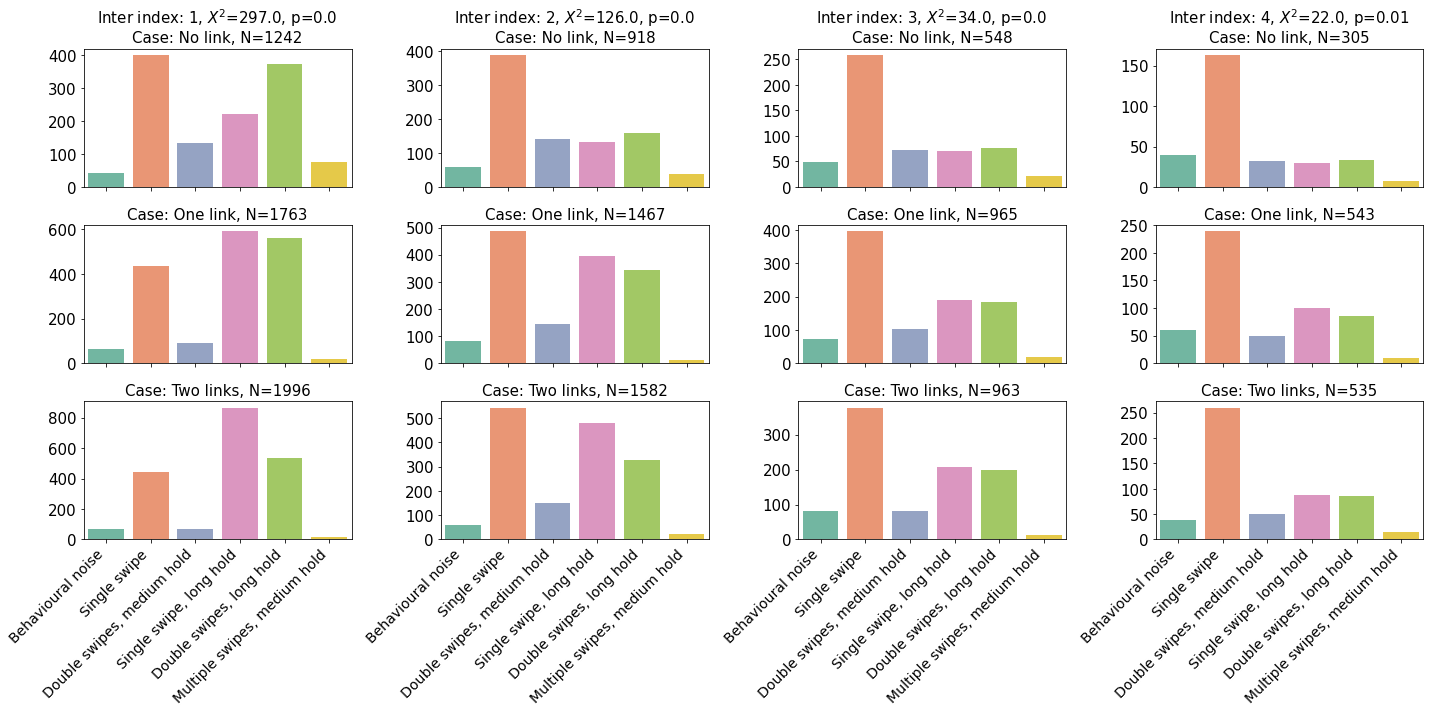

In [238]:
fig, axs = plt.subplots(len(data_wo_congruent.link_cases.unique()), len(indices), figsize=(20, 10))

title_link_cases = [
    'No link',
    'One link',
    'Two links'
]

links_order = [
    '2_no_link',
    '1_no_link_&_1_link',
    '2_links'
]
for i, idx in enumerate(indices):

    df_plot = data_wo_congruent[data_wo_congruent.var_inter_idx == idx]
    df_plot = interventions[interventions.var_inter_idx == idx]

    for j, link_case in enumerate(links_order):
        df_plot2 = df_plot[df_plot.link_cases == link_case]


        sns.countplot(x='assignment_labels_clean', data=df_plot2, order=assign_label_order_clean, palette=assign_label_colors_clean, ax=axs[j,i])
        
        if j == len(interventions.link_cases.unique()) - 1:
            axs[j, i].set_xticklabels(axs[j, i].get_xticklabels(), rotation=45, ha='right')
        else: 
            axs[j, i].set_xticklabels([])

        if j == 0:
            axs[j, i].set_title(f'Inter index: {idx}, $X^2$={np.round(chi2_contingency_all_gt[i, 0])}, p={np.round(chi2_contingency_all_gt[i, 1], 2)} \nCase: {title_link_cases[j]}, N={df_plot2.shape[0]}', fontsize=15)
        else:
            axs[j, i].set_title(f'Case: {title_link_cases[j]}, N={df_plot2.shape[0]}', fontsize=15)
        axs[j, i].set_xlabel('')
        axs[j, i].set_ylabel('')

        plt.setp(axs[j, i].get_yticklabels(), fontsize=15)
        plt.setp(axs[j, i].get_xticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

In general, it seems that in all cases, the distributions of interventions tends towards the one we see at intervention index 4, with a large number of single swipes relative to other interventions. We see that in the case where there are no outgoing links, the distribution of intervention type does not change much following the first interventions, suggesting that a single intervention is usually enough to arrive at a conclusion in those cases. In other cases however, the distribution takes two more steps to "converge", suggesting that those cases usually take more interventions to disentangles. We can look at chi2 values and see that in the first two indices, chi2 are respectively 10 times and 4 times as high as in index 3. This is both dues to a clearer difference in the distribution of performed interventions but also due to the strong fall in number of interventions performed after index 2.

In general we propose that holding is a way to infer link strength and sign while multiple swipes are a way to validate that no relationship exists.

##### 1. No link case

We can see that for cases with no links, participants make more use, relative to other intervention types, of single swipes, long double swipes or long multi swipes. We propose that they are two ways of checking for the lack of presence of links. First, swipe up or down and if the other two variables do not move in way that appears to depend on the swipe, conclude that no connection exists between the cause and candidate effects.

If in doubt, either because of a conservative attitude or because the candidate effects did move in a way that appeared to be ambiguous. Then prefer interventions with more than one swipe rather that simply holding, by following the initial swipes by another or multiple others. We can see this tendency by the larger relative number of wiggles and double swipe interventions.


##### 2. Two links case

Here, we see an overrepresentation of long holds which leads us to propose that this is the bread and butter of link sign and strength detection, given that there is an outgoing link. Here single swipes are made, then when faced with some change in the candidate effects, the node is held to discover the sign and strength of the relation. The facts that it takes participants on average 2 or 3 interventions to arrive at a full conclusion on the outgoing node suggests that they struggle to pay attention to both outgoing effects at the same time and need to focus on one at a time. 

We can see that interventions with more than one swipe are underrepresented compared to the case with no link.


##### 3. One link and one no link

As we would expect from the analysis of the first two cases, the hybrid case where there is only one outgoing link effectively interpolates between the two previous cases. Indeed here, singles swipes and hold and interventions with multiple swipes are roughly equivalently performed in the first two indices, giving credit to the fact that different intervention type suit different link cases.


##### Connecting it to congruence

Perhaps in labelled congruent trials, participants are able to converge quicker, whereas in incongruent trials, they take more interventions (not in raw number of intervention but in specialised interventions), leading to more errors. However, because of participants' ability to dynamically adjust their behaviour in the face of the generated data, in most cases, it allows them to perform almost as well as in congruent cases, leading to a marginal main effect.

#### Congruent trials, interventions distribution per link type and intervention index

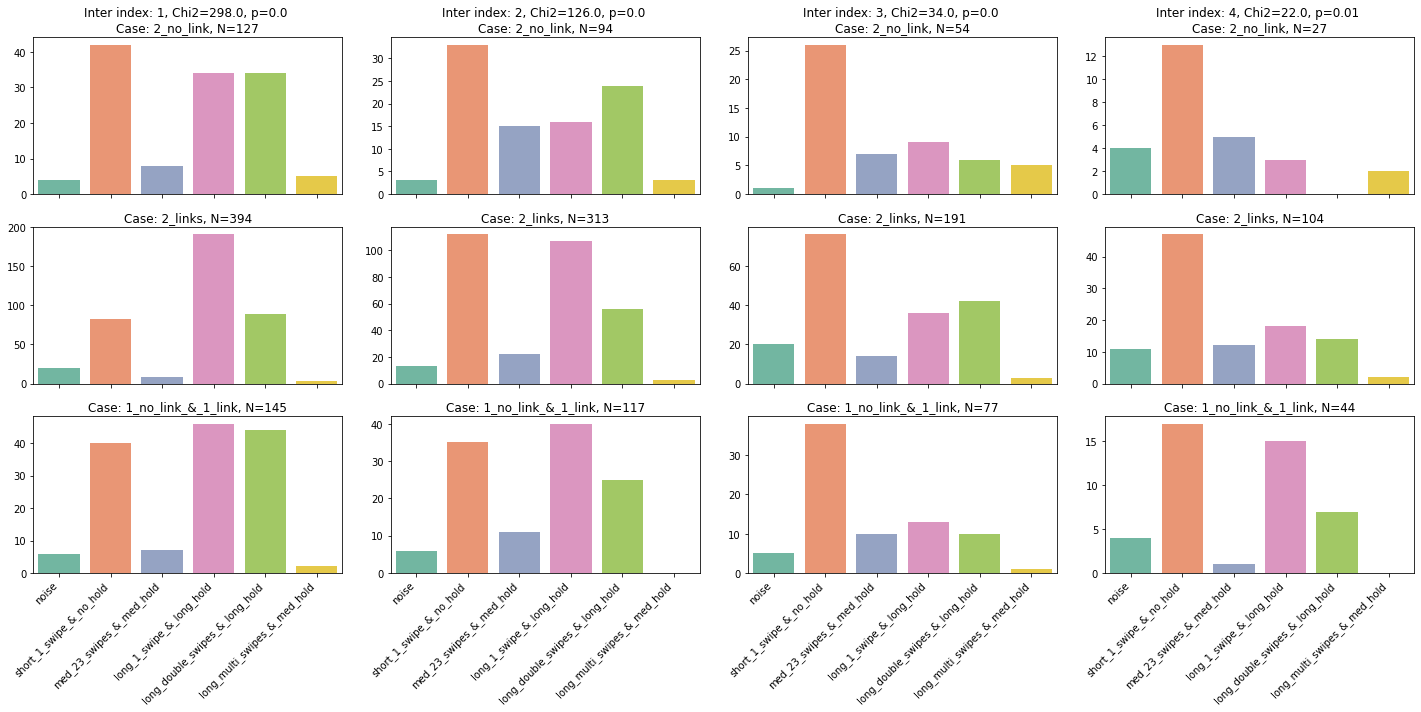

In [ ]:
data_l = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]
data_local = data_l[data_l.trial_type.isin(['congruent'])]

link_types = ['2_no_link', '2_links', '1_no_link_&_1_link']

fig, axs = plt.subplots(len(data_local.link_cases.unique()), len(indices), figsize=(20, 10))

for i, idx in enumerate(indices):

    df_plot = data_local[data_local.var_inter_idx == idx]

    for j, link_case in enumerate(link_types):
        df_plot2 = df_plot[df_plot.link_cases == link_case]

        sns.countplot(x='assignment_labels', data=df_plot2, order=assign_label_order, palette=assign_label_colors, ax=axs[j,i])
        
        if j == len(data_wo_congruent.link_cases.unique()) - 1:
            axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        else: 
            axs[j, i].set_xticklabels([])

        if j == 0:
            axs[j, i].set_title(f'Inter index: {idx}, Chi2={np.round(chi2_contingency_all_gt[i, 0])}, p={np.round(chi2_contingency_all_gt[i, 1], 2)} \nCase: {link_case}, N={df_plot2.shape[0]}')
        else:
            axs[j, i].set_title(f'Case: {link_case}, N={df_plot2.shape[0]}')
        axs[j, i].set_xlabel('')
        axs[j, i].set_ylabel('')

plt.tight_layout()
plt.show()

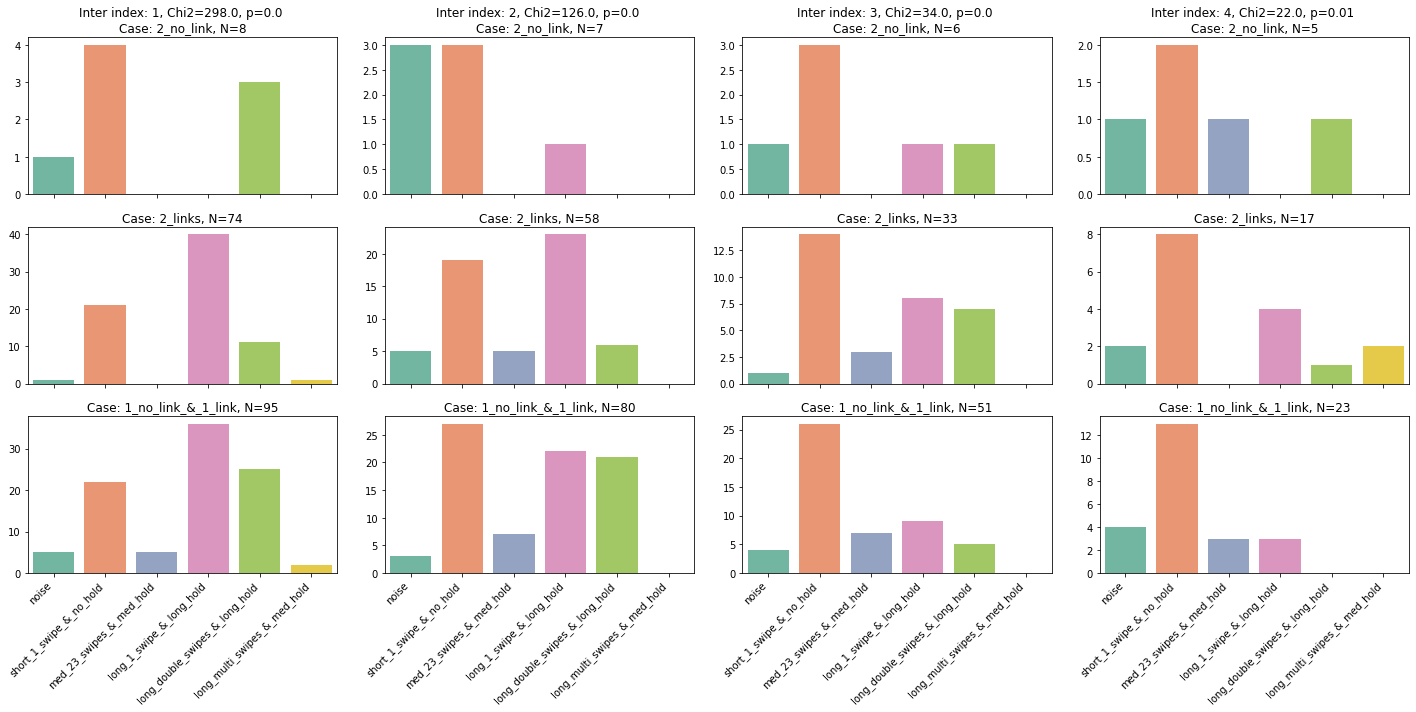

In [ ]:
data_l = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]
data_local = data_l[data_l.trial_type.isin(['incongruent'])]
data_local = data_local[data_local.prior_bf == 1]

link_types = ['2_no_link', '2_links', '1_no_link_&_1_link']

fig, axs = plt.subplots(len(data_local.link_cases.unique()), len(indices), figsize=(20, 10))

for i, idx in enumerate(indices):

    df_plot = data_local[data_local.var_inter_idx == idx]

    for j, link_case in enumerate(link_types):
        df_plot2 = df_plot[df_plot.link_cases == link_case]

        sns.countplot(x='assignment_labels', data=df_plot2, order=assign_label_order, palette=assign_label_colors, ax=axs[j,i])
        
        if j == len(data_wo_congruent.link_cases.unique()) - 1:
            axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        else: 
            axs[j, i].set_xticklabels([])

        if j == 0:
            axs[j, i].set_title(f'Inter index: {idx}, Chi2={np.round(chi2_contingency_all_gt[i, 0])}, p={np.round(chi2_contingency_all_gt[i, 1], 2)} \nCase: {link_case}, N={df_plot2.shape[0]}')
        else:
            axs[j, i].set_title(f'Case: {link_case}, N={df_plot2.shape[0]}')
        axs[j, i].set_xlabel('')
        axs[j, i].set_ylabel('')

plt.tight_layout()
plt.show()

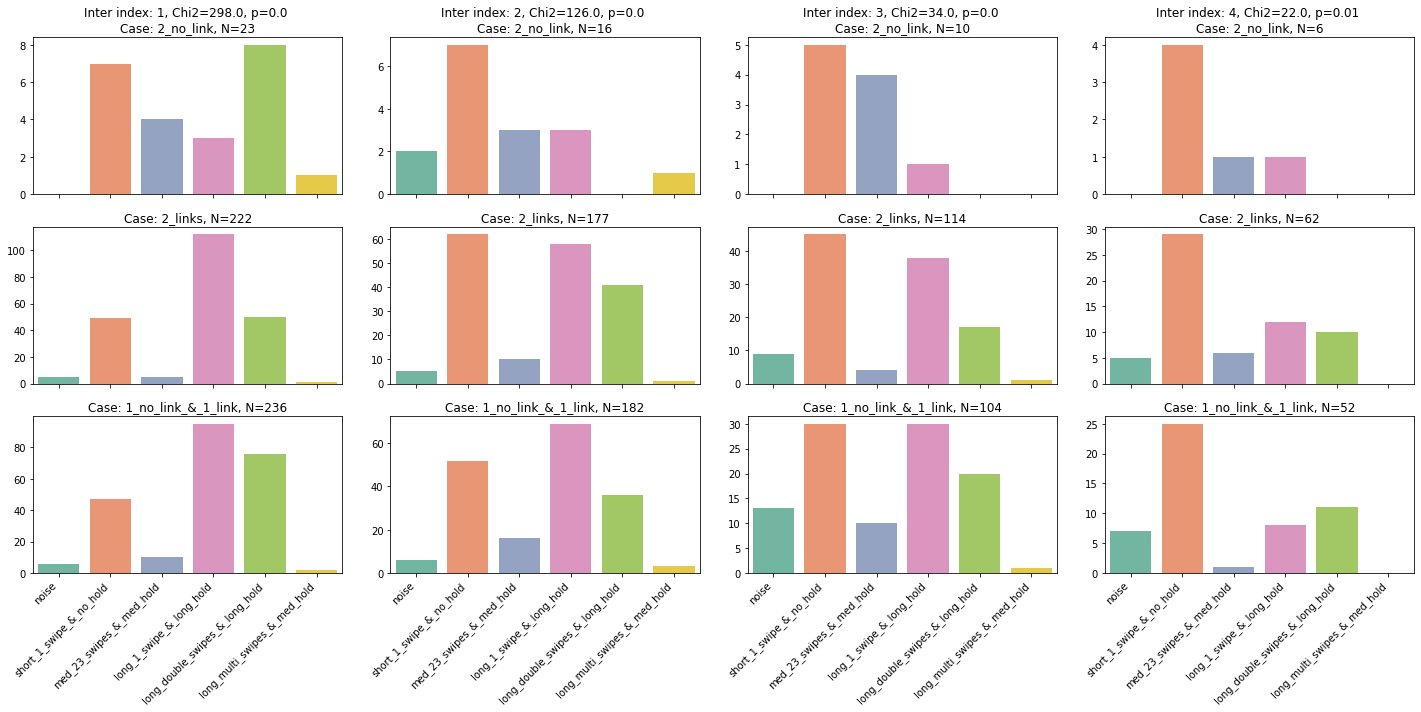

In [ ]:
data_l = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]
data_local = data_l[data_l.trial_type.isin(['incongruent'])]
data_local = data_local[data_local.prior_bf == 0]

link_types = ['2_no_link', '2_links', '1_no_link_&_1_link']

fig, axs = plt.subplots(len(data_local.link_cases.unique()), len(indices), figsize=(20, 10))

for i, idx in enumerate(indices):

    df_plot = data_local[data_local.var_inter_idx == idx]

    for j, link_case in enumerate(link_types):
        df_plot2 = df_plot[df_plot.link_cases == link_case]

        sns.countplot(x='assignment_labels', data=df_plot2, order=assign_label_order, palette=assign_label_colors, ax=axs[j,i])
        
        if j == len(data_wo_congruent.link_cases.unique()) - 1:
            axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        else: 
            axs[j, i].set_xticklabels([])

        if j == 0:
            axs[j, i].set_title(f'Inter index: {idx}, Chi2={np.round(chi2_contingency_all_gt[i, 0])}, p={np.round(chi2_contingency_all_gt[i, 1], 2)} \nCase: {link_case}, N={df_plot2.shape[0]}')
        else:
            axs[j, i].set_title(f'Case: {link_case}, N={df_plot2.shape[0]}')
        axs[j, i].set_xlabel('')
        axs[j, i].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
print(chi2s_prior)


[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


In [ ]:
print(chi2s_gt)

[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


In [ ]:
chi2s = np.zeros((len(indices), 2))

for i in range(freq_data.shape[0]):
    chi2s[i, :] = stats.chi2_contingency(freq_data_gt[i, :, :])[:2]

chi2s

array([[64.8813017 ,  0.        ],
       [30.06230739,  0.00083677],
       [31.25462481,  0.00053252],
       [ 0.        ,  0.        ]])

### Measuring the dependency to the prior structure

- Chi-square test for the distribution of intervention type for each intervention index
- Look at difference between congruent and incongruent trials

#### Takeaway:

- Participants interventions' choices seem to depend on the outgoing links of the held variable.
- The noise category is the only one which is only marginally significant, which is expected at it should not vary between cases. The fact that it still does is probably both a functon of sample size and the clustering algorithm which maybe put a few meaningful interventions in the noise category
- Participants intervene as many times in all cases as the distribution of intervention per cases closely track the di
- They also used much less long-1-swipe-long-hold interventions compared to cases where there was a link, suggesting the long hold was a preferred tools for detecting the direction of links.
- They also used more short-1-swipe-no-hold and med-23-swipes-med-hold, i.e. shorter interventions.
- The last noteworthy difference is that in the cases where there is no link, participants performed more long-multi-swipes-med-hold, or wiggling, interventions than in the other cases. This gives some evidence for the fact wiggles are a good choice of interventions for checking for non-correlation, i.e. validating that there are no links.

#### Theoretical insights:

- We could hypothise that these are "testing" interventions, meaning that they give an initial represent of whether there is a link or not. In the no link case, these are often enough to arrive at a conclusion, whereas in the cases where there is at least one link, subsequent interventions are needed to uncover the strength. This would also explained the lower number of interventions in the no-link cases compared to the other two.
- Where a normative agent can perform link detection AND strength estimation in one go, and as such can get away with simply swiping up and down, people may need to separate the two. They may tend to perform one swipe to get an initial estimate of whether there are links or not and then either use a wiggle to validate that there are no links or 1 or several long swipe and hold to estimate the strength and direction. Either in two separate interventions or one long one.
- As such it is possible that a lot of the single swipes in the no-link case would have been single swipes and hold if the participant had noticed that there was at least one link.

#### To Do

- Look at information gained per case and per intervention type
- Look at sequences of interventions in different cases to gain insight into the role that the different types of intervention fulfill: link detection, strength estimation, no-link validation. 
- We would expect shorter interventions to come first and be followed up with longer interventions depending on the case

Distribution of links cases: [0.24835033 0.39912018 0.35252949]
Distribution of interventions number per links cases: [0.23800623 0.39418484 0.36780893]


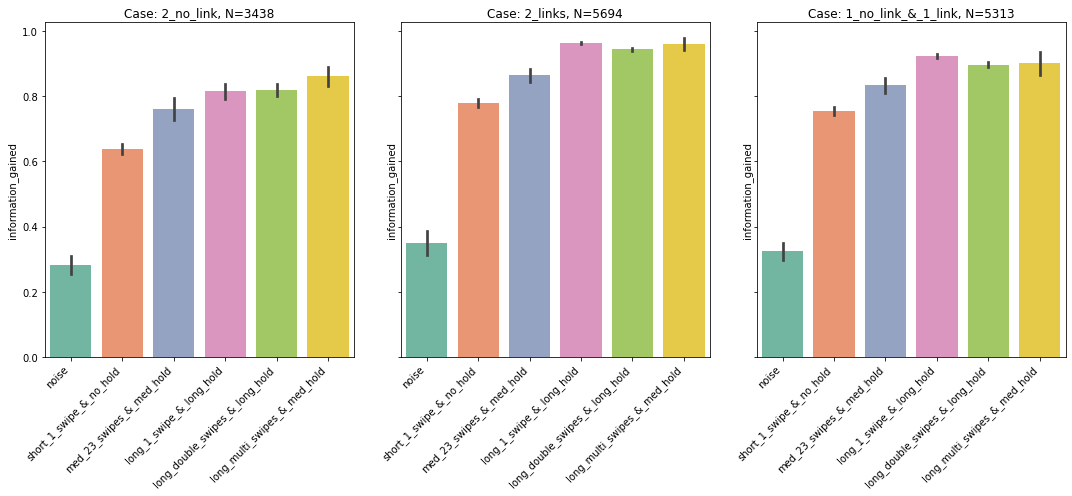

In [ ]:
fig, axs = plt.subplots(1, len(interventions.link_cases.unique()), figsize=(15, 7), sharey=True)

freq_int_link_cases = np.zeros(interventions.link_cases.unique().size)

for i, case in enumerate(interventions.link_cases.unique()):
    df_plot = interventions[interventions.link_cases == case]

    sns.barplot(x='assignment_labels', y='information_gained', data=df_plot, ax=axs[i], order=assign_label_order, palette=assign_label_colors)
    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Case: {case}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')

    freq_int_link_cases[i] = df_plot.shape[0]

print(f'Distribution of links cases: {links_cases_freq / links_cases_freq.sum()}')
print(f'Distribution of interventions number per links cases: {freq_int_link_cases / freq_int_link_cases.sum()}')
plt.tight_layout()
plt.show()
    


#### Takeaway

- It is subtle but one can see that the wiggles or long-multi-swipes-med-hold interventions are the most informative on average in the no link case than in the cases where there is at least one link.
- This shows that participants 

Num interventions congruent: 1926
Num interventions incongruent: 1834


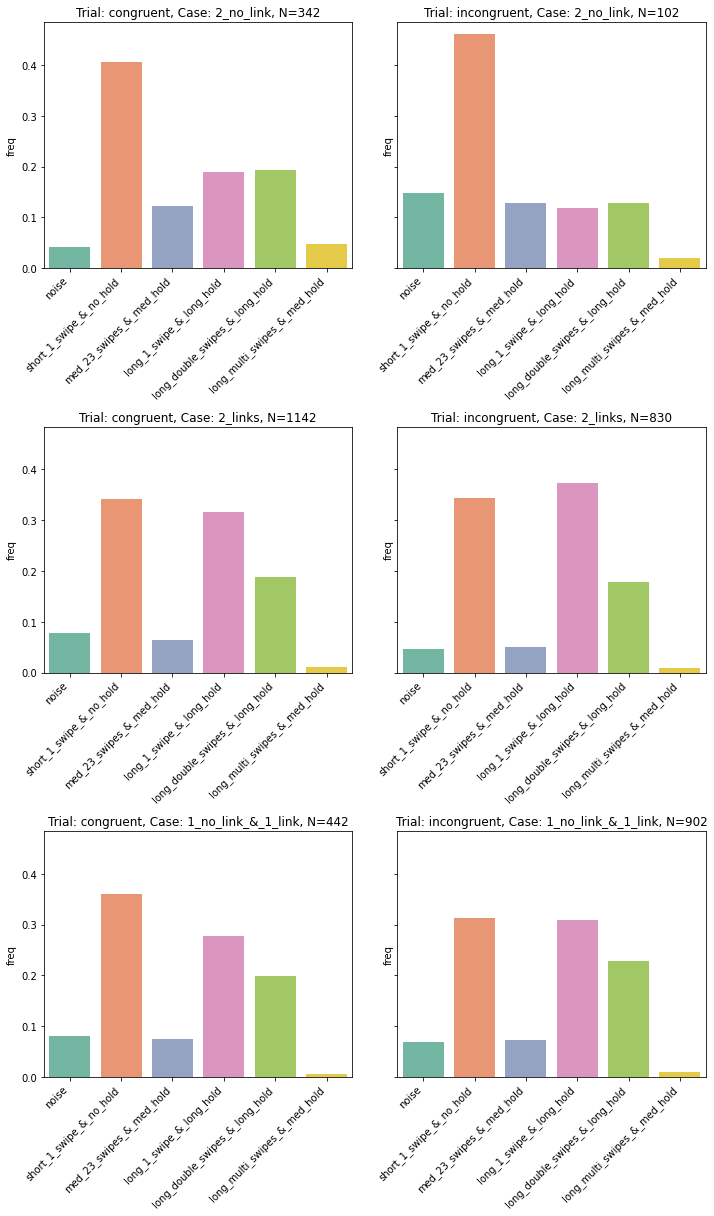

In [ ]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

link_cases = interventions.link_cases.unique()
freq_data = np.zeros((len(trials_diff), len(link_cases), len(assign_order)))

freq_exp = np.zeros((num_cols, interventions.assignment_labels.unique().size))
gen_freq = np.zeros(interventions.assignment_labels.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = interventions[interventions.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()

fig, axs = plt.subplots(len(link_cases), len(trials_diff), figsize=(10, 17), sharey=True)


for i, t_d in enumerate(trials_diff):
    df_plot = inter_34[inter_34.trial_type == t_d]
    print(f'Num interventions {t_d}: {len(df_plot)}')
    for j, case in enumerate(link_cases):
        df_plot1 = df_plot[df_plot.link_cases == case]
        df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
        for k, int_type in enumerate(assign_label_order):
            #print(int_type)
            freq_data[i, j, k] = df_plot1[df_plot1.assignment_labels == int_type].shape[0]
            df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j, k] / df_plot1.assignment_labels.size]

        sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[j, i], order=assign_label_order, palette=assign_label_colors)
        axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        axs[j, i].set_title(f'Trial: {t_d}, Case: {case}, N={df_plot1.shape[0]}')
        axs[j, i].set_xlabel('')

plt.tight_layout()
plt.show()

Num interventions congruent: 1926
Num interventions incongruent: 1834


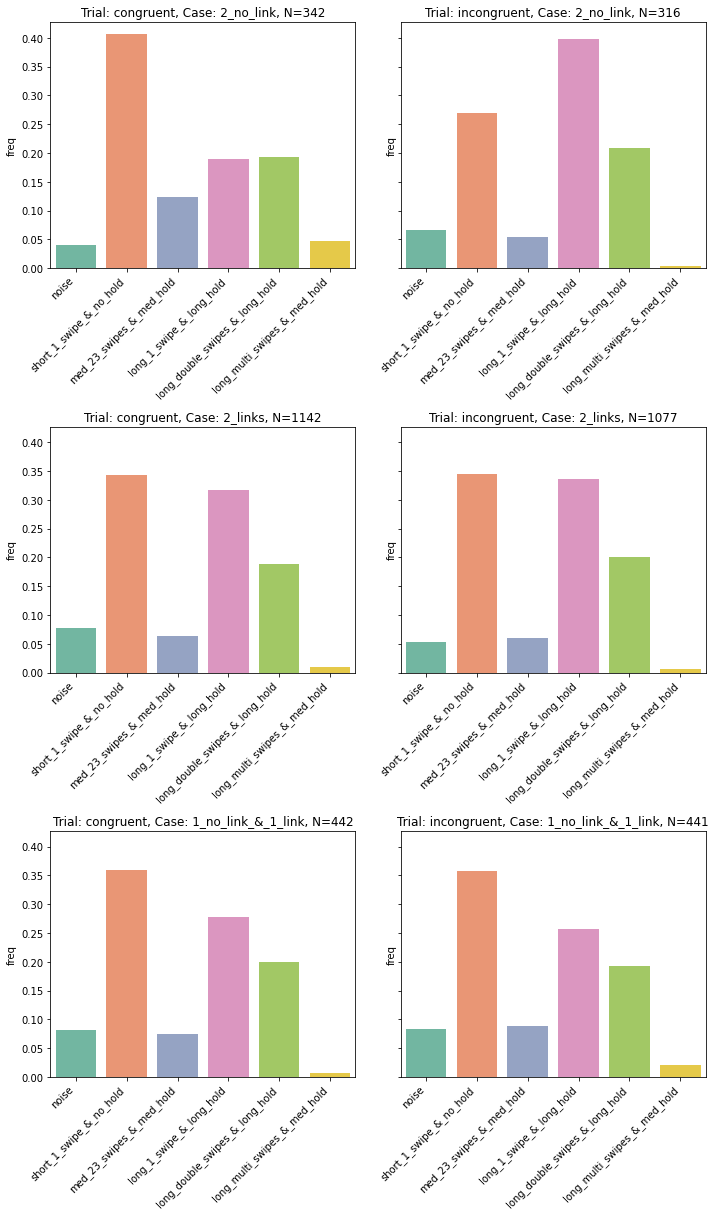

In [ ]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

link_cases = interventions.link_cases.unique()
freq_data = np.zeros((len(trials_diff), len(link_cases), len(assign_order)))

freq_exp = np.zeros((num_cols, interventions.assignment_labels.unique().size))
gen_freq = np.zeros(interventions.assignment_labels.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = interventions[interventions.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()

fig, axs = plt.subplots(len(link_cases), len(trials_diff), figsize=(10, 17), sharey=True)


for i, t_d in enumerate(trials_diff):
    df_p = inter_34[inter_34.trial_type == t_d]
    df_plot = df_p
    print(f'Num interventions {t_d}: {len(df_plot)}')
    for j, case in enumerate(link_cases):
        df_plot1 = df_plot[df_plot.link_cases_prior == case]
        df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
        for k, int_type in enumerate(assign_label_order):
            #print(int_type)
            freq_data[i, j, k] = df_plot1[df_plot1.assignment_labels == int_type].shape[0]
            df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j, k] / df_plot1.assignment_labels.size]

        sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[j, i], order=assign_label_order, palette=assign_label_colors)
        axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        axs[j, i].set_title(f'Trial: {t_d}, Case: {case}, N={df_plot1.shape[0]}')
        axs[j, i].set_xlabel('')

plt.tight_layout()
plt.show()

Num interventions congruent: 1926
Num interventions incongruent: 1834


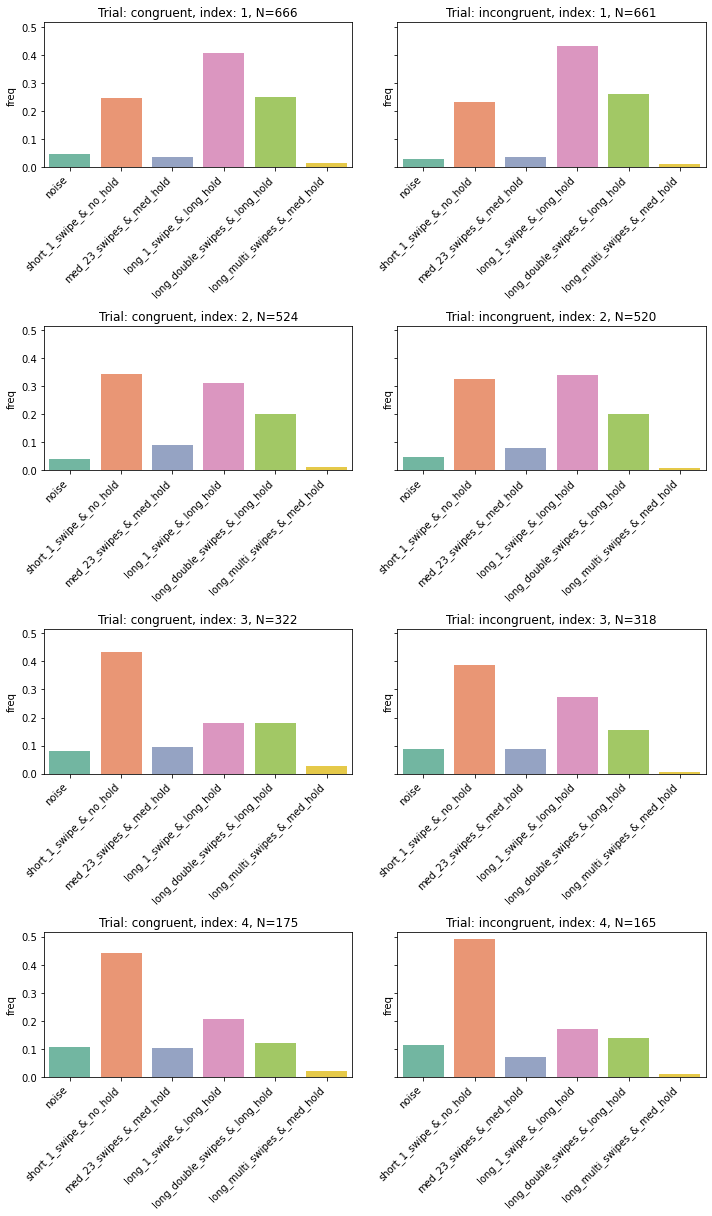

In [ ]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]

trials_diff = ['congruent', 'incongruent']

indices = np.arange(1, 5)
link_cases = interventions.link_cases.unique()
freq_data = np.zeros((len(trials_diff), len(indices), len(assign_order)))

freq_exp = np.zeros((num_cols, interventions.assignment_labels.unique().size))
gen_freq = np.zeros(interventions.assignment_labels.unique().size)

for j, int_type in enumerate(assign_label_order):
    gen_freq[j] = interventions[interventions.assignment_labels == int_type].assignment_labels.count()
gen_freq = gen_freq / gen_freq.sum()


fig, axs = plt.subplots(len(indices), len(trials_diff), figsize=(10, 17), sharey=True)


for i, t_d in enumerate(trials_diff):
    df_p = inter_34[inter_34.trial_type == t_d]
    df_plot = df_p
    print(f'Num interventions {t_d}: {len(df_plot)}')
    for j, idx in enumerate(indices):
        df_plot1 = df_plot[df_plot.var_inter_idx == idx]
        df_plot2 = pd.DataFrame(columns=['assignment_labels', 'freq'])
        for k, int_type in enumerate(assign_label_order):
            #print(int_type)
            freq_data[i, j, k] = df_plot1[df_plot1.assignment_labels == int_type].shape[0]
            df_plot2.loc[df_plot2.index.size] = [int_type, freq_data[i, j, k] / df_plot1.assignment_labels.size]

        sns.barplot(x='assignment_labels', y='freq', data=df_plot2, ax=axs[j, i], order=assign_label_order, palette=assign_label_colors)
        axs[j, i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        axs[j, i].set_title(f'Trial: {t_d}, index: {idx}, N={df_plot1.shape[0]}')
        axs[j, i].set_xlabel('')

plt.tight_layout()
plt.show()

## Preliminary conclusions

- Nothing allows clear discrimination between congruent and incongruent trials. Specifically, interventions made in the latter seem as informative in isolation than in those taken in the former. This could suggest that participant make redundant interventions in incongruent trials.
- There are small differences in interventions types frequencies between both conditions suggesting that the initial swipes are less done and more replaced with longer interventions (look at intervention time between both condition)
- Participants interventions seem to be less dependent on the prior graph than they are on the ground truth graph. This is to be expected, however, at index 2, participants' choices still depend on prior graph, even in incongruent trials


## To Do

- Look at intervention type given prior link values (extract and add these as column) - OK
- Look at interventions in time rather than frequency - OK
- Split sample between best fit by prior and others and have a look



Only labelled trials


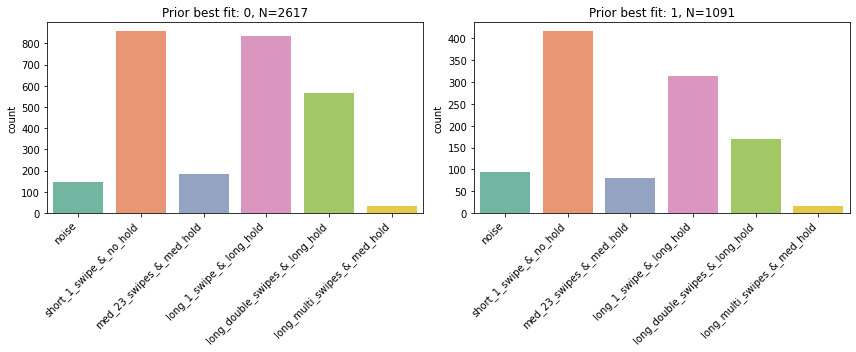

In [ ]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]
trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34[inter_34.trial_type.isin(trials_diff)]

prior_bf = np.array([0, 1])

fig, axs = plt.subplots(1, len(prior_bf), figsize=(12, 5))

for i, prior in enumerate(prior_bf):
    df_plot = inter_34_prior[inter_34_prior.prior_bf == prior]

    sns.countplot(x='assignment_labels', data=df_plot, order=assign_label_order, palette=assign_label_colors, ax=axs[i])

    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Prior best fit: {prior}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')

print('Only labelled trials')
plt.tight_layout()
plt.show()

All trials


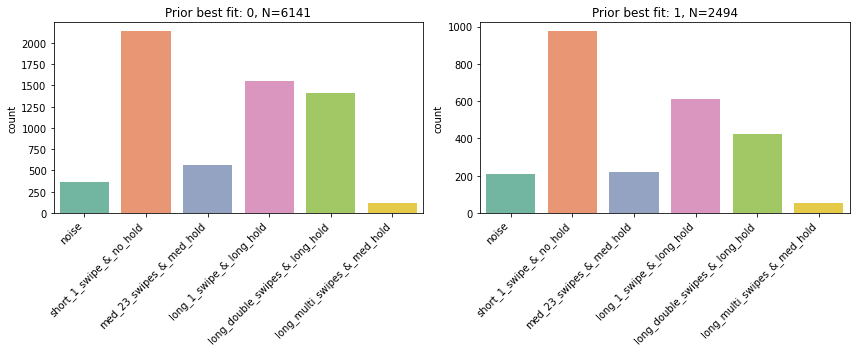

In [ ]:
inter_34 = interventions[interventions.experiment.isin(['experiment_3', 'experiment_4'])]
trials_diff = ['congruent', 'incongruent']

inter_34_prior = inter_34#[~inter_34.trial_type.isin(trials_diff)]

prior_bf = np.array([0, 1])

fig, axs = plt.subplots(1, len(prior_bf), figsize=(12, 5))

for i, prior in enumerate(prior_bf):
    df_plot = inter_34_prior[inter_34_prior.prior_bf == prior]

    sns.countplot(x='assignment_labels', data=df_plot, order=assign_label_order, palette=assign_label_colors, ax=axs[i])

    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    axs[i].set_title(f'Prior best fit: {prior}, N={df_plot.shape[0]}')
    axs[i].set_xlabel('')

print('All trials')
plt.tight_layout()
plt.show()

### Order of interventions

Exploring how intervention index, i.e. order in which interventions are performed, is linked with intervention type.

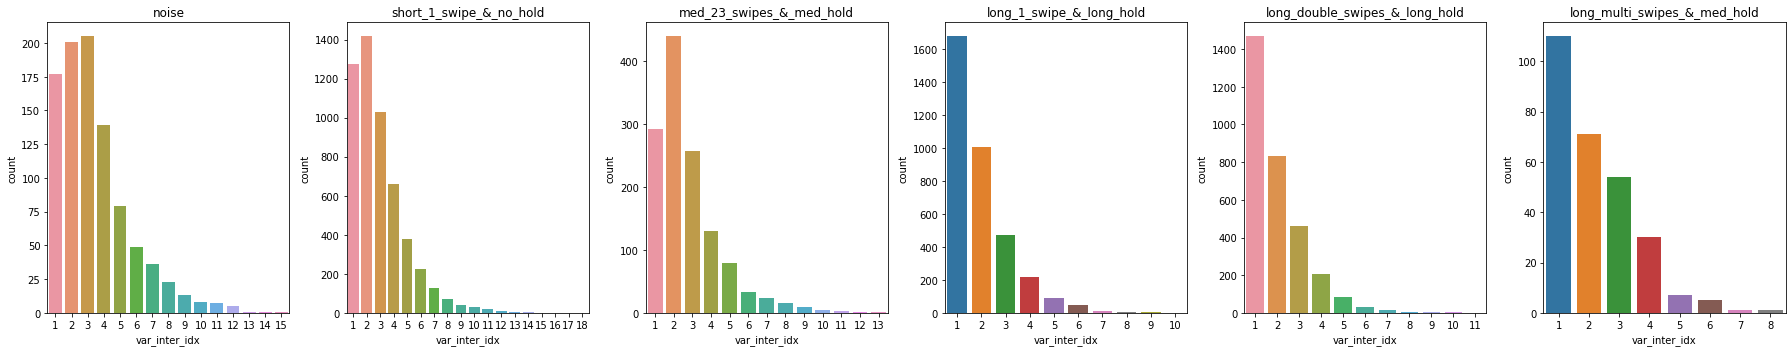

In [ ]:
fig, axs = plt.subplots(1, len(assign_label_order), figsize=(25, 5))

#sns.set_palette('Set1')
for i, assign in enumerate(assign_label_order):
    df_plot = interventions[interventions.assignment_labels == assign]
    sns.countplot(x='var_inter_idx', data=df_plot, ax=axs[i])
    axs[i].set_title(f'{assign}')

plt.tight_layout()
plt.show()

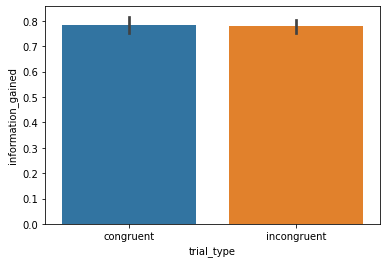

In [ ]:
sns.barplot(x='trial_type', y='information_gained', data=inter_34[inter_34.trial_type.isin(trials_diff)])
plt.show()

freq_data

# APPENDIX OR BIN

## Logic for generating an intervention from summary statistics

In [ ]:


def generate_inter(inter, begin=0):
    times = np.arange(int(inter[0]*5))

    frames_mode = int(times.size * inter[-1])


    begin = 0

    if inter[2] == 0:
        mode_periods_length = np.array([times.size])
        travel_periods_length = np.array([])
    elif inter[2] == 1:
        mode_periods_length = np.array([frames_mode])
        travel_periods_length = np.array([times.size - frames_mode])
    else:
        mode_periods_length = np.zeros(int(inter[2]) - 1)
        for i in range(mode_periods_length.size):
            if i == mode_periods_length.size - 1:
                mode_periods_length[i] = frames_mode - mode_periods_length.sum()
            else:
                mode_periods_length[i] = int(frames_mode / mode_periods_length.size)
        mode_periods_length = mode_periods_length.astype(int) 

        frames_travel = times.size - frames_mode

        travel_periods_length = np.zeros(int(inter[2]))
        for i in range(travel_periods_length.size):
            if i == travel_periods_length.size - 1:
                travel_periods_length[i] = frames_travel - travel_periods_length.sum()
            else:
                travel_periods_length[i] = int(frames_travel / travel_periods_length.size)
        travel_periods_length = travel_periods_length.astype(int)



    if inter[2] == 0:
        values = inter[1] * np.ones(times.size)
    else:
        values = np.zeros(times.size)

        travel = True
        travel_idx = 0
        mode_idx = 0
        for i in range(mode_periods_length.size + travel_periods_length.size):
            pos_init = int(travel_periods_length[:travel_idx].sum() + mode_periods_length[:mode_idx].sum())

            if travel:
                pos_final = int(travel_periods_length[:travel_idx+1].sum() + mode_periods_length[:mode_idx].sum())
                if i == 0:

                    values[pos_init:pos_final] = np.linspace(begin, inter[1], travel_periods_length[travel_idx]+2)[1:-1]
                    mode_state = inter[1]
                else:
                    values[pos_init:pos_final] = np.linspace(values[pos_init-1], -1*values[pos_init-1], travel_periods_length[travel_idx]+2)[1:-1]
                    mode_state = -1*values[pos_init-1]

                travel_idx += 1
                travel = False
            else:
                pos_final = int(travel_periods_length[:travel_idx].sum() + mode_periods_length[:mode_idx+1].sum())

                values[pos_init:pos_final] = mode_state * np.ones(mode_periods_length[mode_idx])


                mode_idx += 1
                travel = True

    return values


[ 0.34575913 23.43895085  0.001       0.24834698]
[ 0.41508657 35.75261564  0.001       0.32258846]
[ 0.3241912  25.47227044  4.92440655  0.24217839]
[ 0.17626141 17.55407714  0.63606849  0.0798397 ]
[ 0.38568893 36.45872114  0.001       0.17229916]
[ 0.1612844  10.4929364   0.40962769  0.1346178 ]


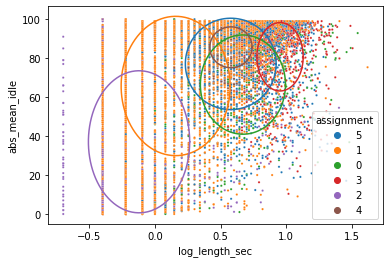

In [ ]:
interventions.assignment = interventions.assignment.astype(str)
interventions.swipes = interventions.swipes.astype(float)

select = [0, 1]

comp_select = ['0', '1', '2', '3', '4', '5']

colors = sns.color_palette()

data_loc = interventions[interventions.assignment.isin(comp_select)]

assigns = data_loc.assignment.unique()

#print(assigns)

ax = sns.scatterplot(data=data_loc, x=features[select[0]], y=features[select[1]], hue="assignment", palette=colors[:len(assigns)], s=5)
#ax.set(yscale='log')
for j, comp in enumerate(data_loc.assignment.unique()):
    #print(comp)
    comp_n = int(comp)

    c_means = gm.means_[comp_n, :]
    #print(c_means)
    c_var = gm.covariances_[comp_n, :]**(1/2)
    print(c_var)
    if len(c_var.shape) < 2:
        u = c_means[select[0]]  #x-position of the center
        v = c_means[select[1]]   #y-position of the center
        a = c_var[select[0]]    #radius on the x-axis
        b = c_var[select[1]]    #radius on the y-axis

        t = np.linspace(0, 2*np.pi, 100)
        plt.plot( u+a*np.cos(t) , v+b*np.sin(t), color=colors[j] )

    else:
        # Construct a smaller covariances matrix
        mus = np.array(c_means[select])

        c_var = c_var**2

        cov = np.array([[c_var[select[0], select[0]], c_var[select[0], select[1]]], [c_var[select[1], select[0]], c_var[select[1], select[1]]]])

        x, y = np.mgrid[ax.get_xlim()[0]:ax.get_xlim()[1]:.01, ax.get_ylim()[0]:ax.get_ylim()[1]:.01]
        pos = np.dstack((x, y))
        rv = stats.multivariate_normal(mus, cov)
        ax.contour(x, y, rv.pdf(pos), levels=0, color=colors[j])
        
#plt.grid(color='lightgray',linestyle='--')
plt.show()

interventions.assignment = interventions.assignment.astype(int)